In [216]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import (
    mean_squared_log_error,
    mean_absolute_error,
    mean_squared_error,
)
from xgboost import DMatrix, train, plot_importance, plot_tree

from sklearn.linear_model import Ridge

In [217]:
train_data = pd.read_csv("./data/train.csv")
test_data = pd.read_csv("./data/test.csv")

In [218]:
train_data.head(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228


In [219]:
test_data.head(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.75,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.30,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1


In [220]:
test_data['Item_Outlet_Sales'] = np.nan

#concatenating the datasets
data = pd.concat([train_data, test_data], ignore_index=True)

# EDA

In [221]:
data.head(20)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
6,FDO10,13.650,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350


In [222]:
print(f"Number of Features : {data.shape[1]}")
print(f"Number of Observations : {data.shape[0]}")

Number of Features : 12
Number of Observations : 14204


In [223]:
print('Number of Numerical Features :',data.dtypes[data.dtypes!=object].size)
print('Number of Categorial Features :',data.dtypes[data.dtypes==object].size)
print("Categorical Features: ",data.dtypes[data.dtypes==object])

Number of Numerical Features : 5
Number of Categorial Features : 7
Categorical Features:  Item_Identifier         object
Item_Fat_Content        object
Item_Type               object
Outlet_Identifier       object
Outlet_Size             object
Outlet_Location_Type    object
Outlet_Type             object
dtype: object


In [224]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14204 non-null  object 
 1   Item_Weight                11765 non-null  float64
 2   Item_Fat_Content           14204 non-null  object 
 3   Item_Visibility            14204 non-null  float64
 4   Item_Type                  14204 non-null  object 
 5   Item_MRP                   14204 non-null  float64
 6   Outlet_Identifier          14204 non-null  object 
 7   Outlet_Establishment_Year  14204 non-null  int64  
 8   Outlet_Size                10188 non-null  object 
 9   Outlet_Location_Type       14204 non-null  object 
 10  Outlet_Type                14204 non-null  object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 1.3+ MB


In [225]:
data.describe(include='all')

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
count,14204,11765.000000,14204,14204.000000,14204,14204.000000,14204,14204.000000,10188,14204,14204,8523.000000
unique,1559,NaN,5,NaN,16,NaN,10,NaN,3,3,4,NaN
top,FDU15,NaN,Low Fat,NaN,Fruits and Vegetables,NaN,OUT027,NaN,Medium,Tier 3,Supermarket Type1,NaN
freq,10,NaN,8485,NaN,2013,NaN,1559,NaN,4655,5583,9294,NaN
mean,NaN,12.792854,NaN,0.065953,NaN,141.004977,NaN,1997.830681,NaN,NaN,NaN,2181.288914
std,NaN,4.652502,NaN,0.051459,NaN,62.086938,NaN,8.371664,NaN,NaN,NaN,1706.499616
min,NaN,4.555000,NaN,0.000000,NaN,31.290000,NaN,1985.000000,NaN,NaN,NaN,33.290000
25%,NaN,8.710000,NaN,0.027036,NaN,94.012000,NaN,1987.000000,NaN,NaN,NaN,834.247400
50%,NaN,12.600000,NaN,0.054021,NaN,142.247000,NaN,1999.000000,NaN,NaN,NaN,1794.331000
75%,NaN,16.750000,NaN,0.094037,NaN,185.855600,NaN,2004.000000,NaN,NaN,NaN,3101.296400


In [226]:
data.isnull().sum()

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
dtype: int64

#### Drawing the distribution and box plots of the numerical data

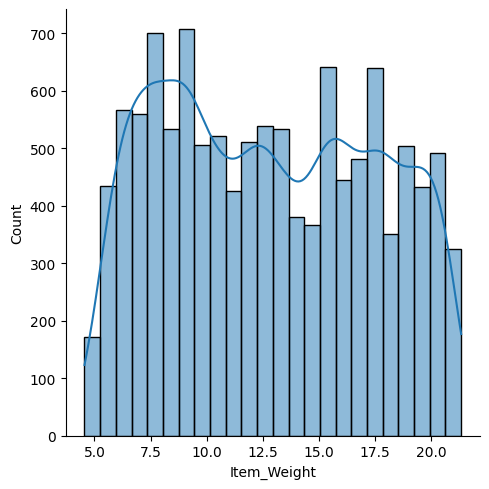

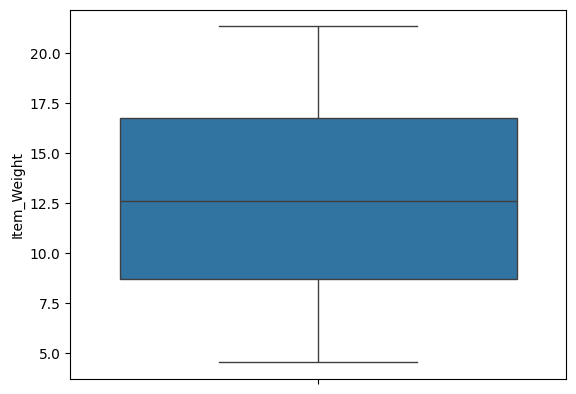

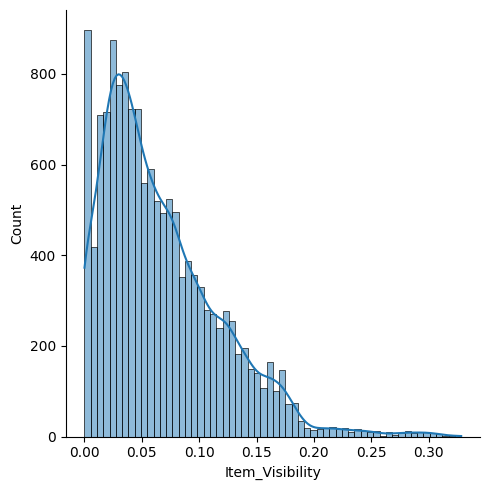

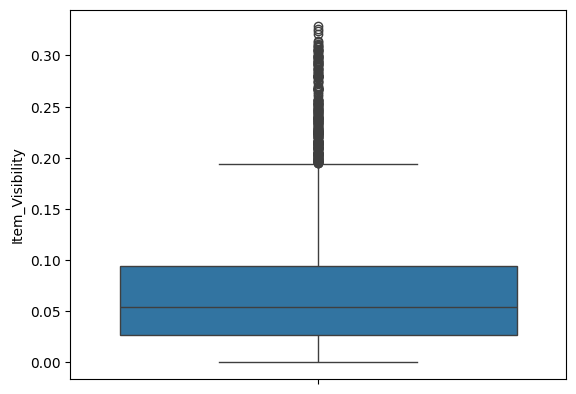

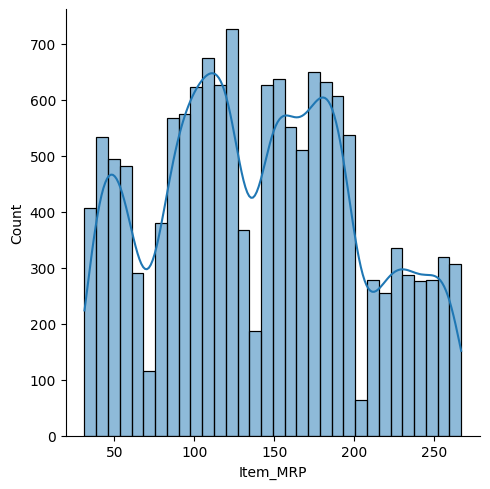

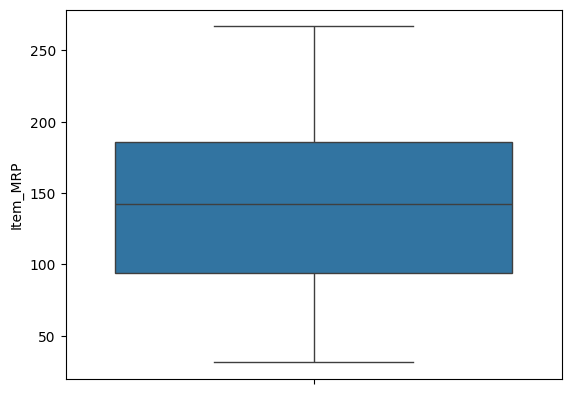

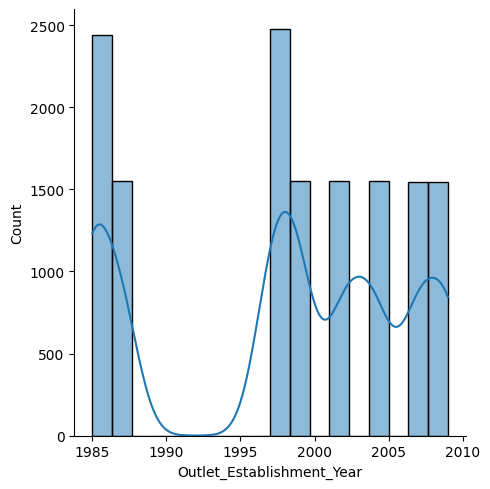

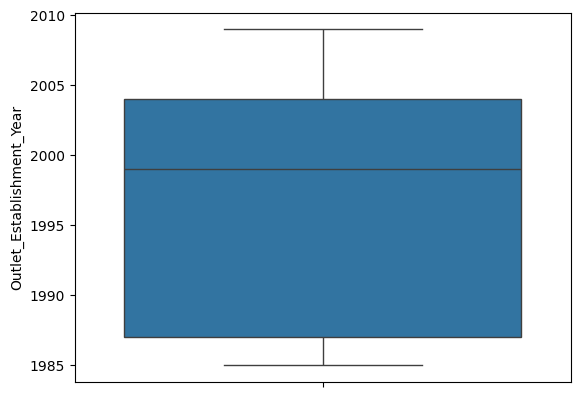

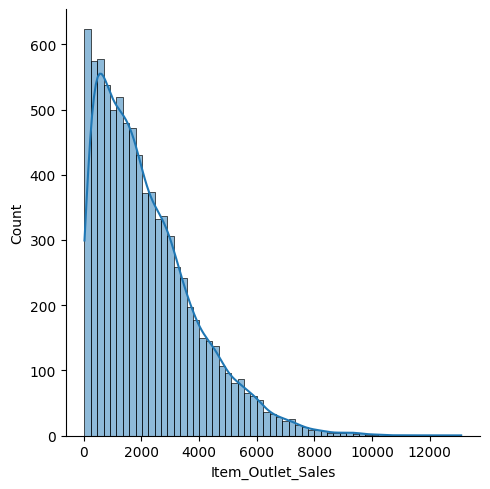

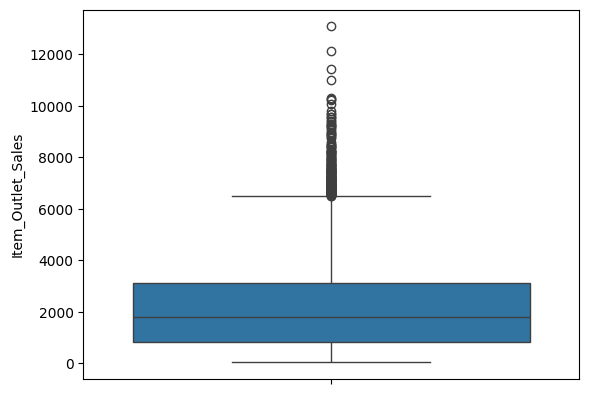

In [227]:
for i in data.select_dtypes(include="number"):
    sns.displot(data[i], kde="True")
    plt.show()
    sns.boxplot(data[i])
    plt.show()

<Axes: xlabel='count', ylabel='Item_Type'>

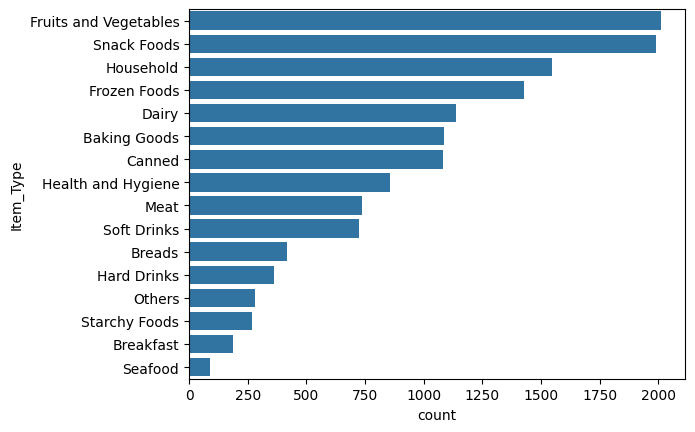

In [228]:
sns.countplot(data=data, y="Item_Type", order=data["Item_Type"].value_counts().index)

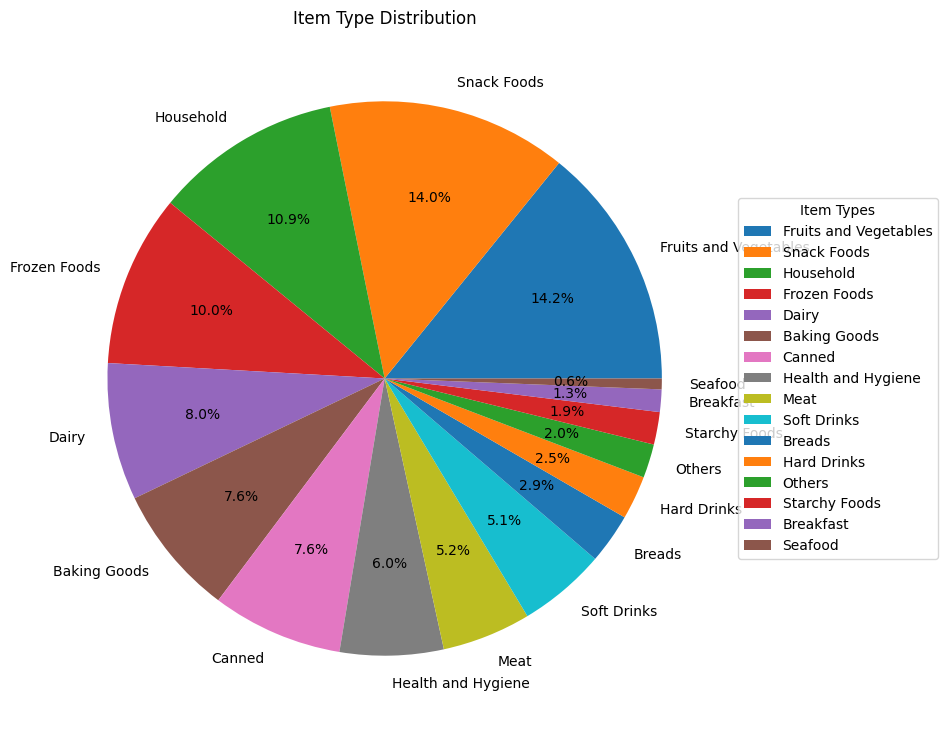

In [229]:
plt.figure(figsize=(15, 9))

plt.pie(
    data["Item_Type"].value_counts(),
    labels=data["Item_Type"].value_counts().index,
    autopct="%1.1f%%",
    pctdistance=0.67,
)
plt.title("Item Type Distribution")
plt.legend(title="Item Types", bbox_to_anchor=(1, 0.5), loc="center left")

plt.show()

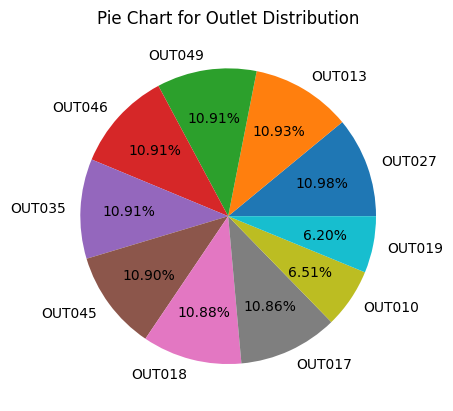

In [230]:
plt.title("Pie Chart for Outlet Distribution")
plt.pie(
    data["Outlet_Identifier"].value_counts(),
    labels=data["Outlet_Identifier"].value_counts().index,
    pctdistance=0.67,
    autopct="%.2f%%",
)
plt.show()

# Data Visualisation

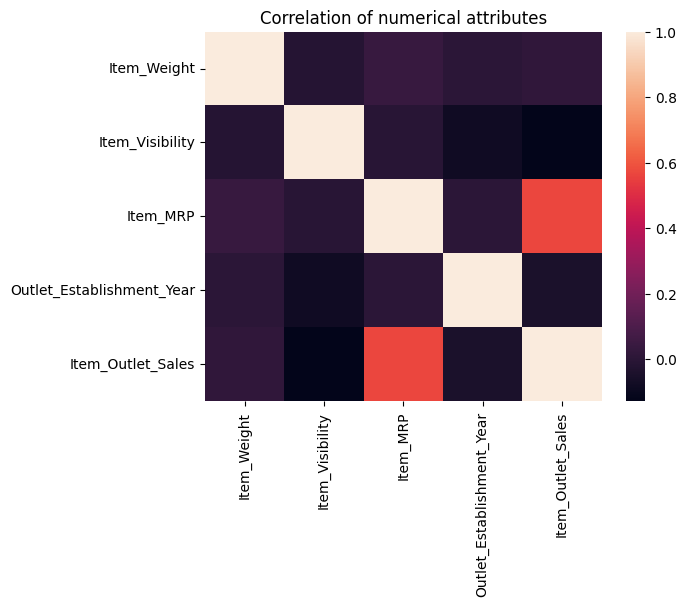

In [231]:
corr_matrix = data.select_dtypes(include="number").corr()
plt.title("Correlation of numerical attributes")
sns.heatmap(corr_matrix)
plt.show()

**From the above correlation matrix, we can easily assume that ITEM_MRP is the most important feature in determing the ITEM_OUTLET_SALES**

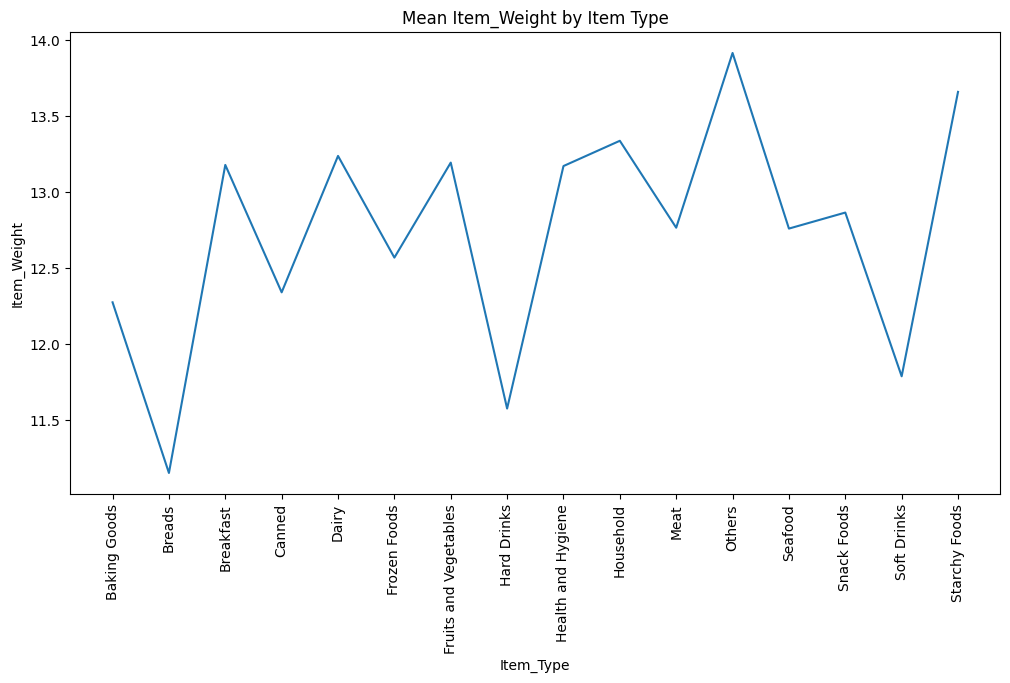

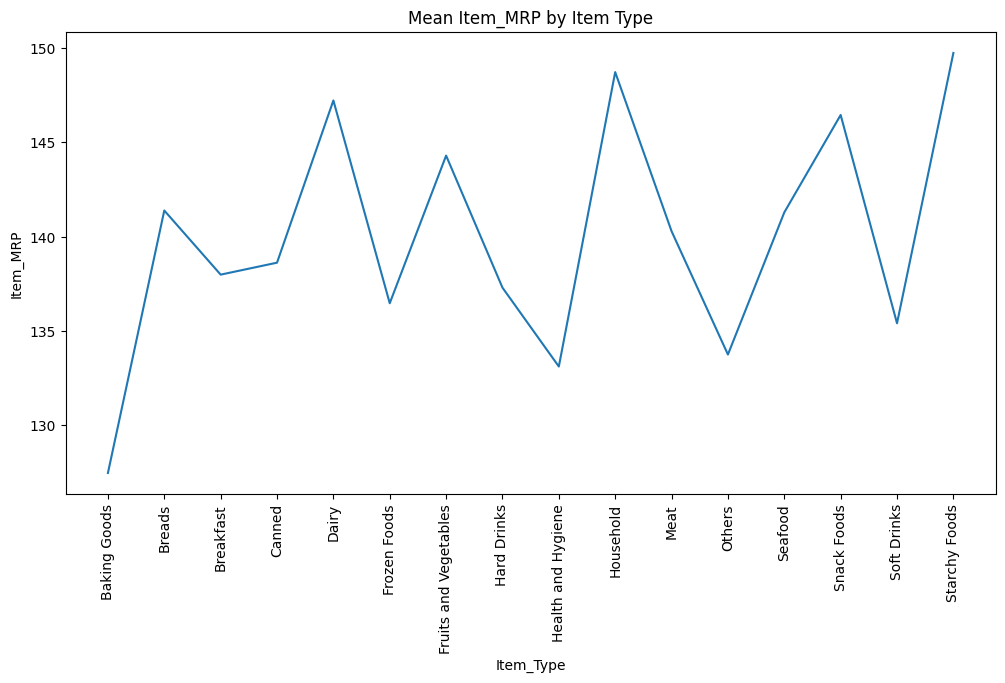

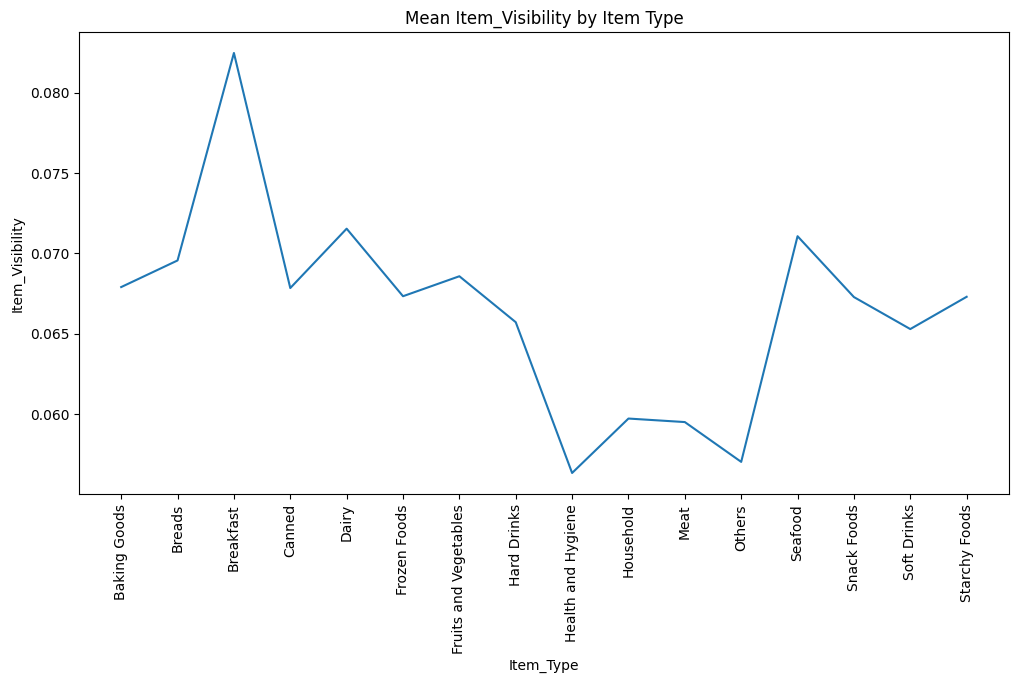

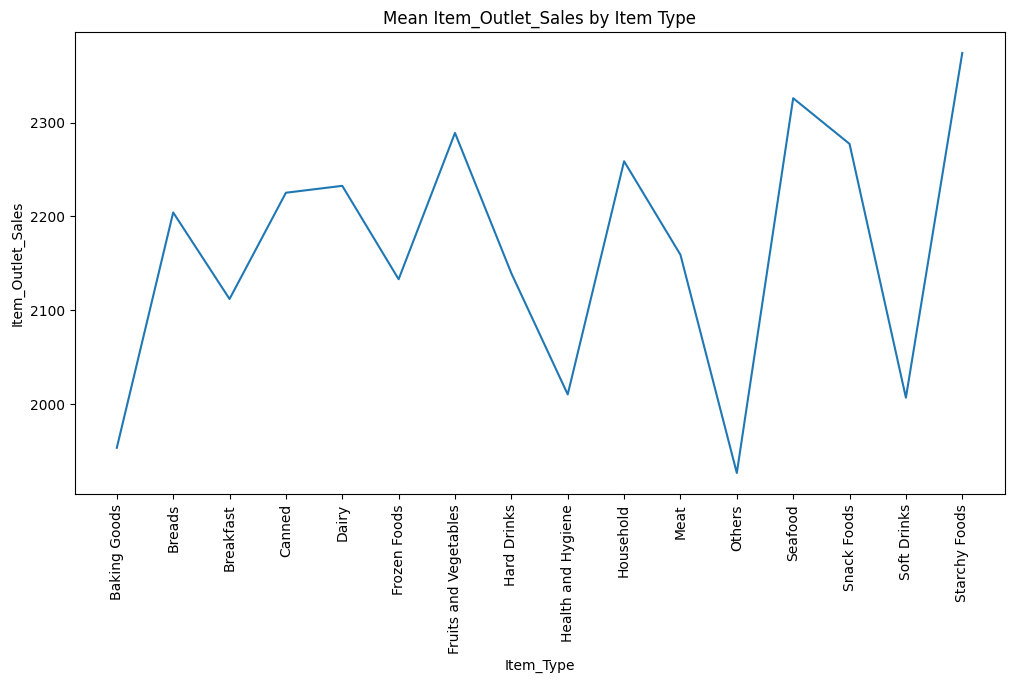

In [232]:
for i in ["Item_Weight","Item_MRP","Item_Visibility","Item_Outlet_Sales"]:
    plt.figure(figsize=(12, 6))
    sns.lineplot(x="Item_Type", y=i, data=data[["Item_Type",i]].groupby(["Item_Type"]).mean())
    plt.xticks(rotation=90)
    plt.title(f'Mean {i} by Item Type')
    plt.show()


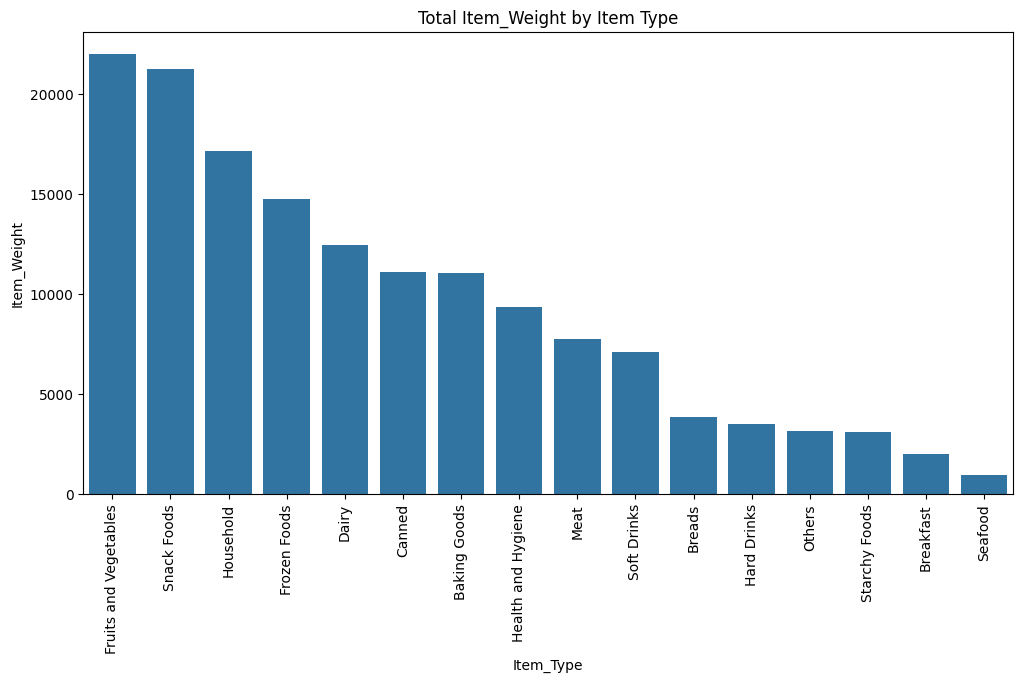

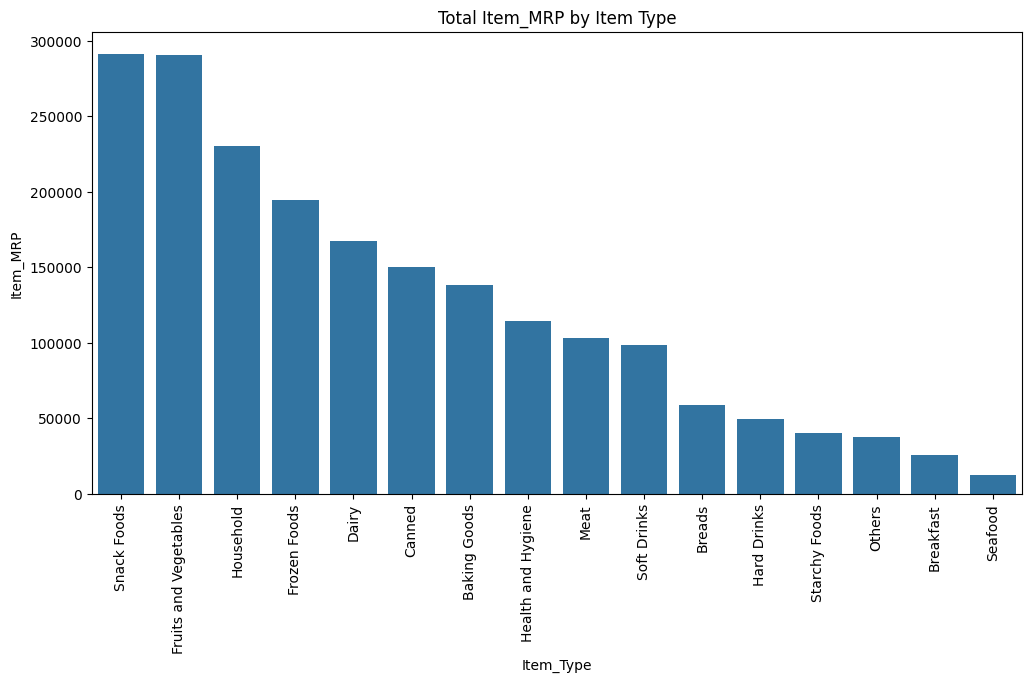

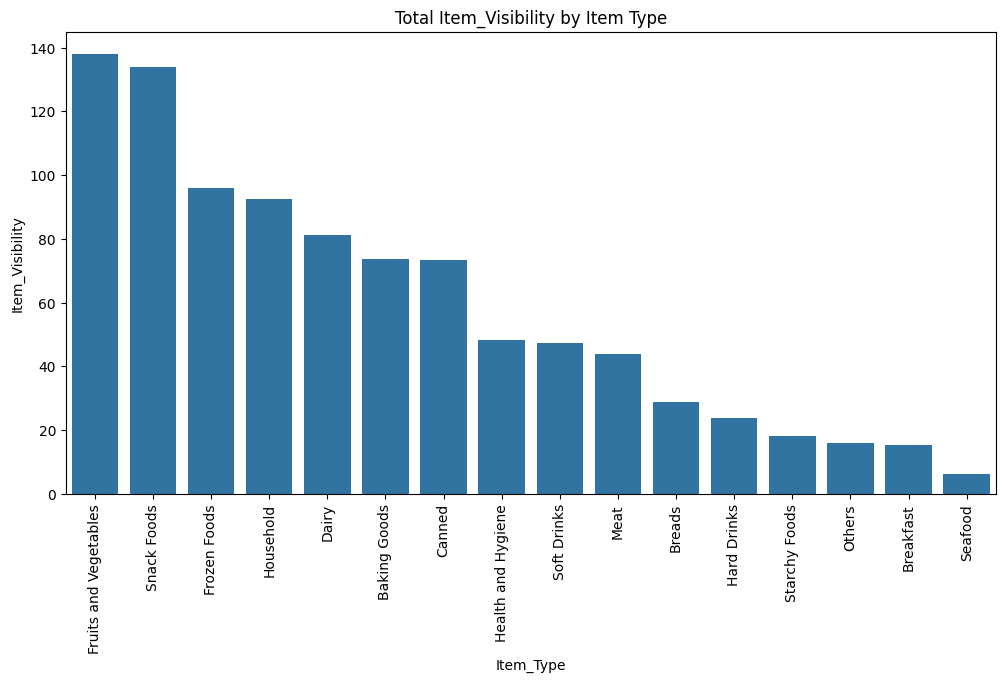

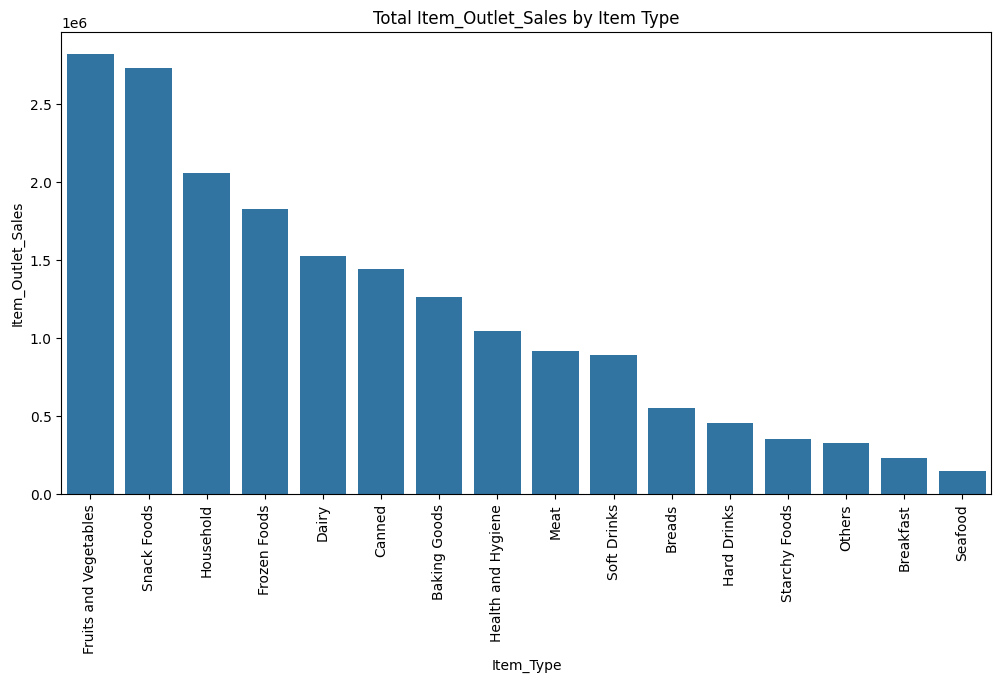

In [233]:
for i in ["Item_Weight","Item_MRP","Item_Visibility","Item_Outlet_Sales"]:
    plt.figure(figsize=(12, 6))
    sns.barplot(x="Item_Type", y=i, data=data[["Item_Type",i]].groupby(["Item_Type"]).sum().sort_values([i],ascending=False
                                                                                                        ))
    plt.xticks(rotation=90)
    plt.title(f'Total {i} by Item Type')
    plt.show()


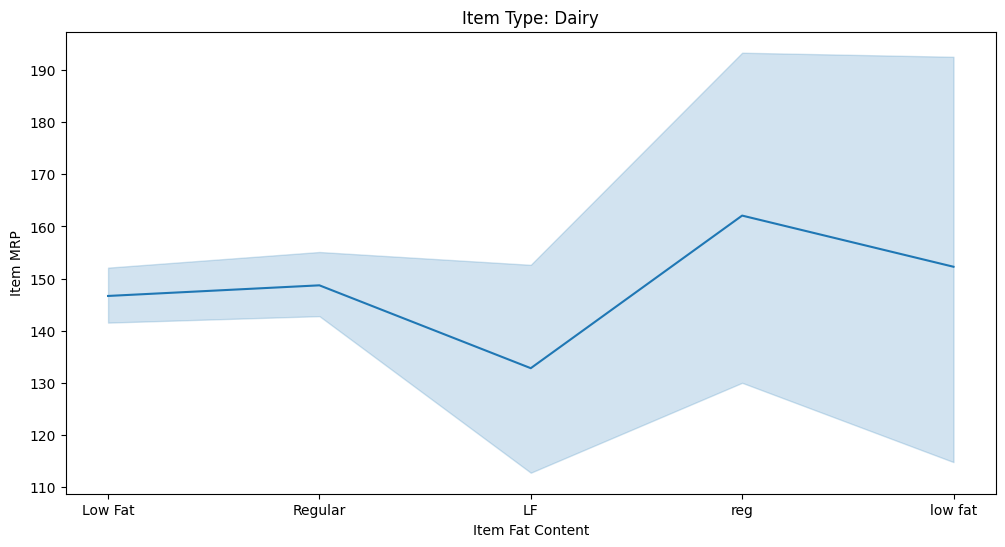

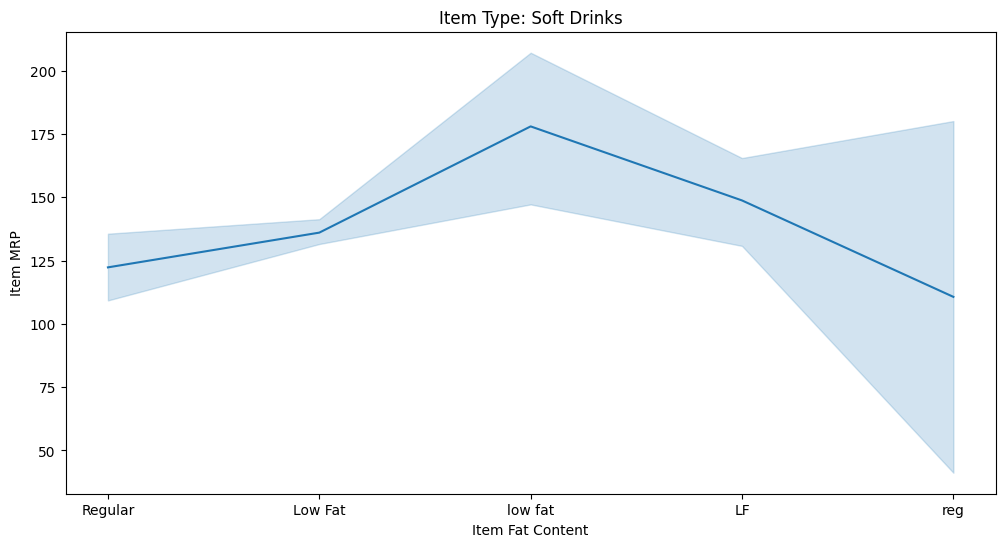

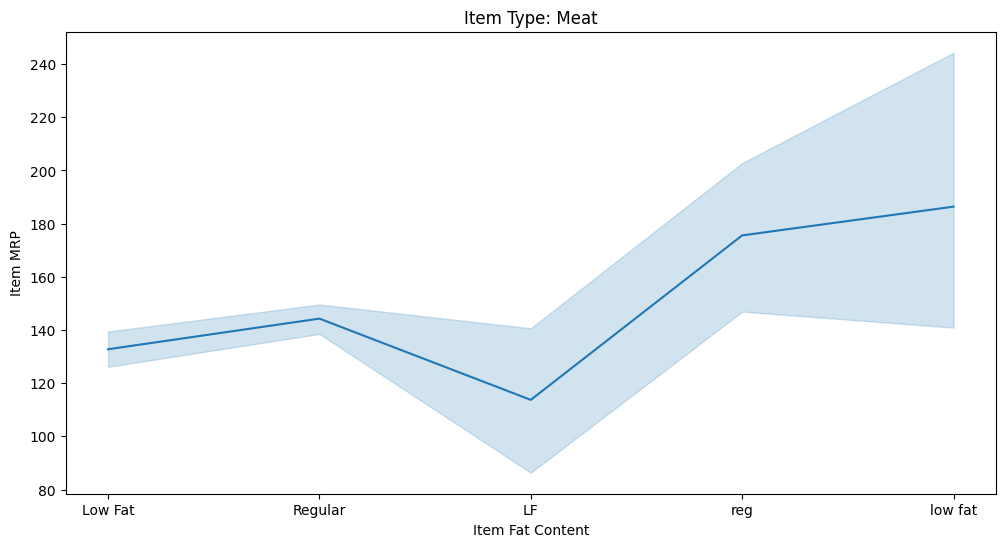

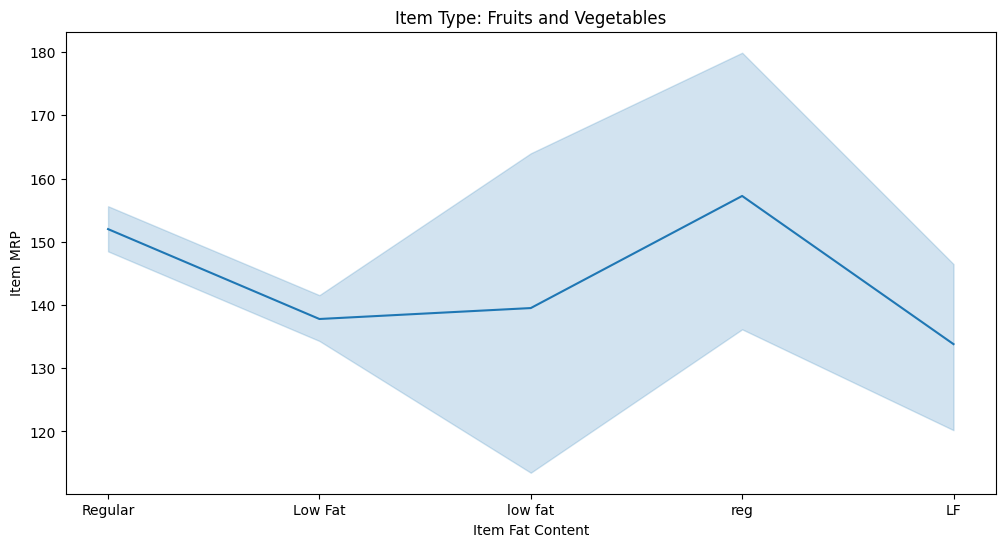

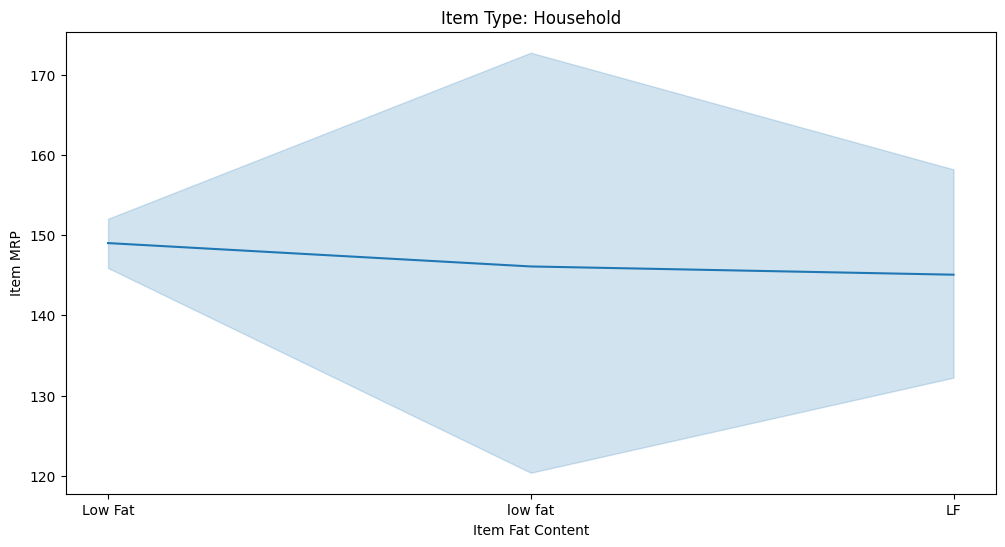

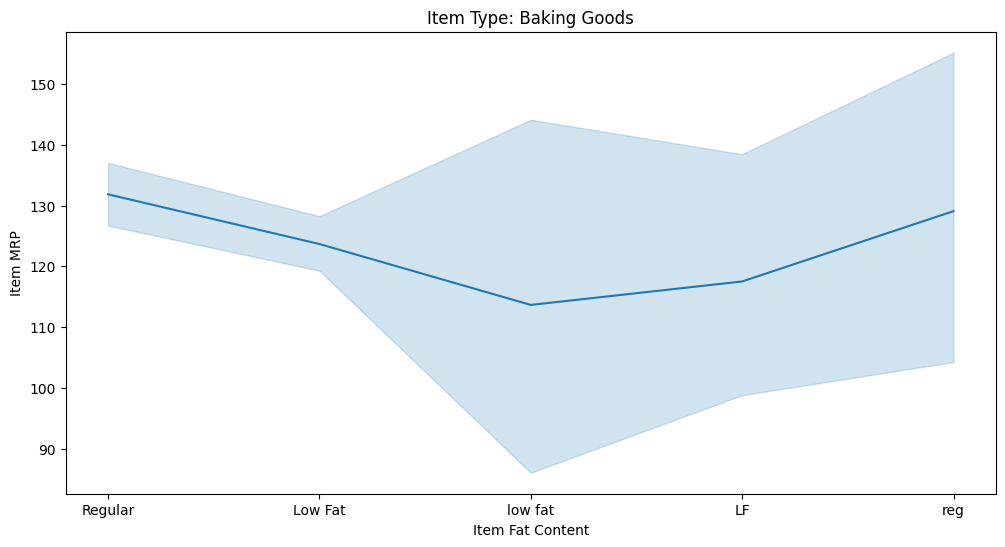

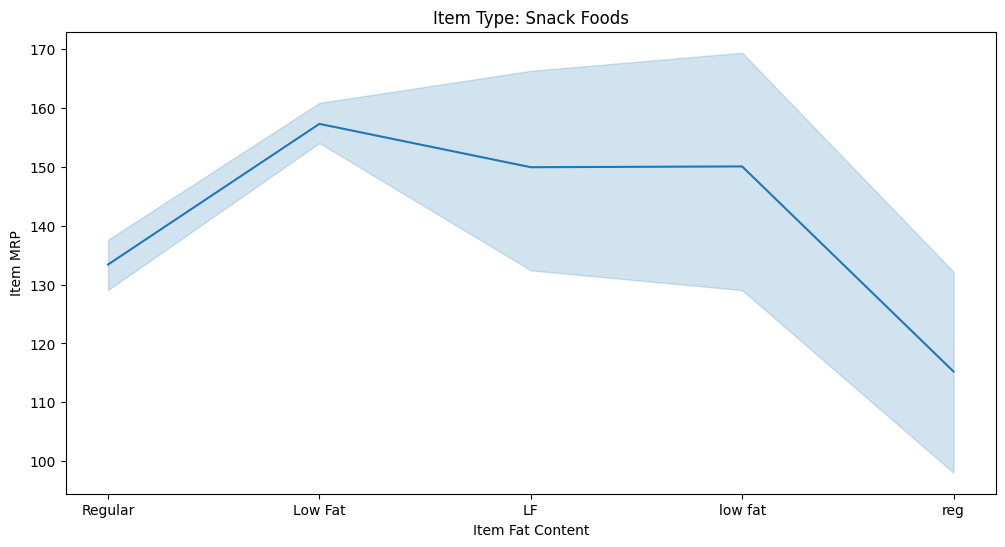

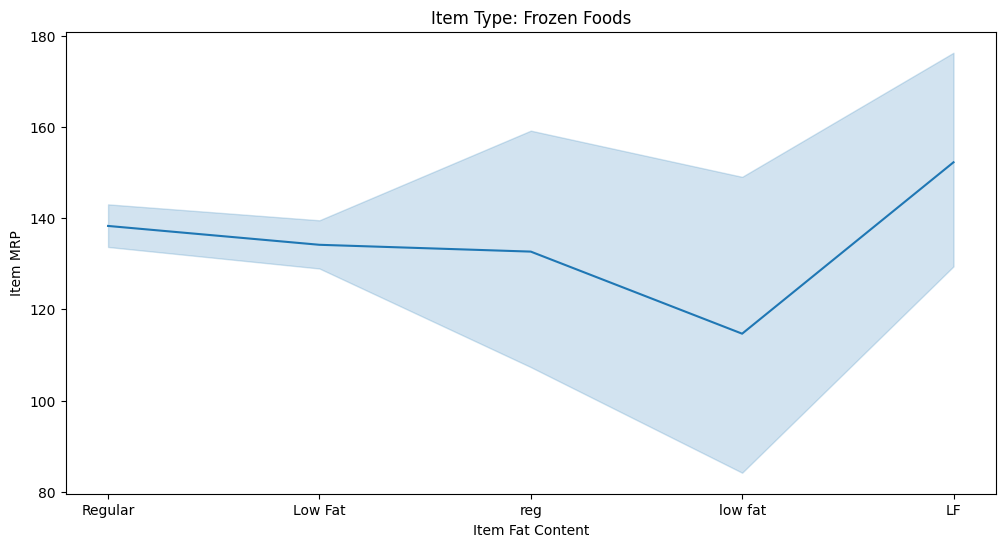

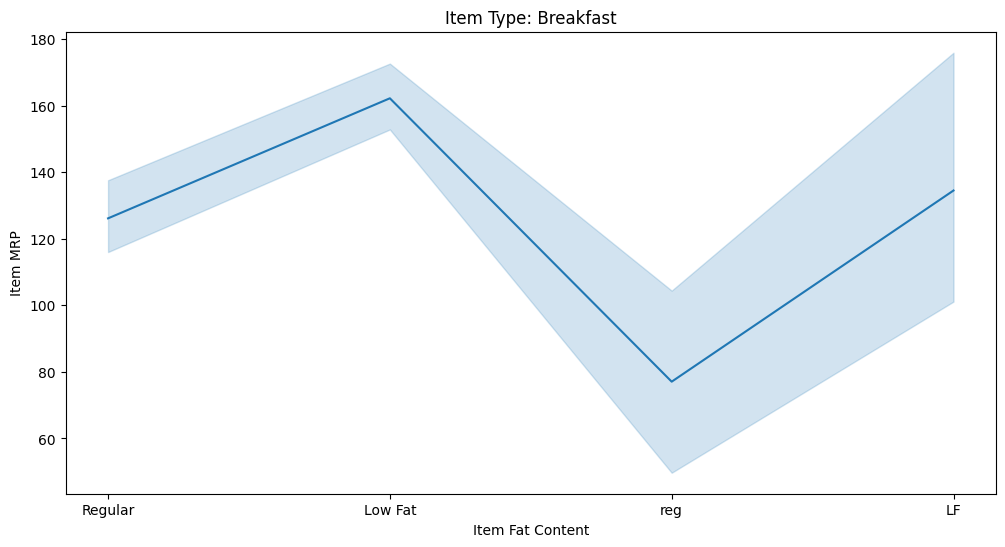

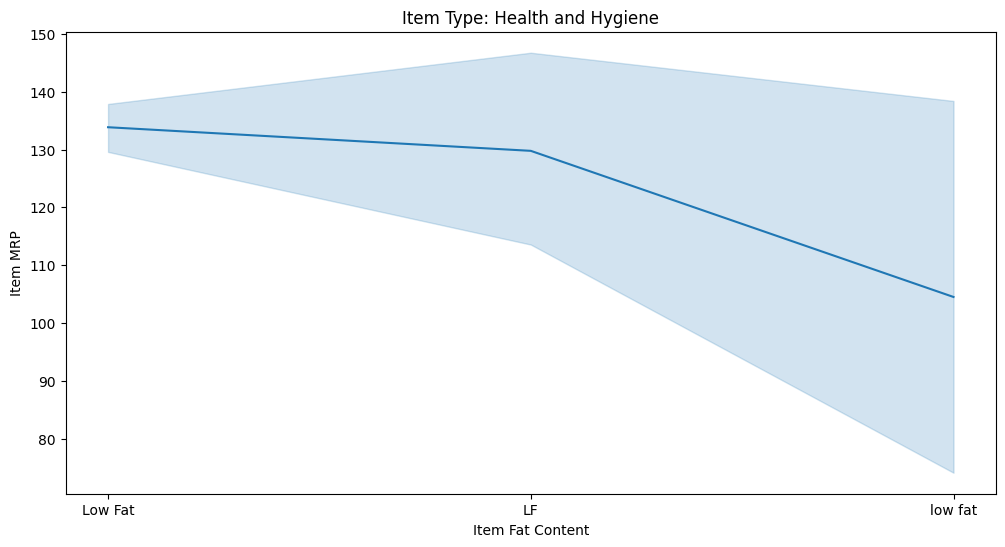

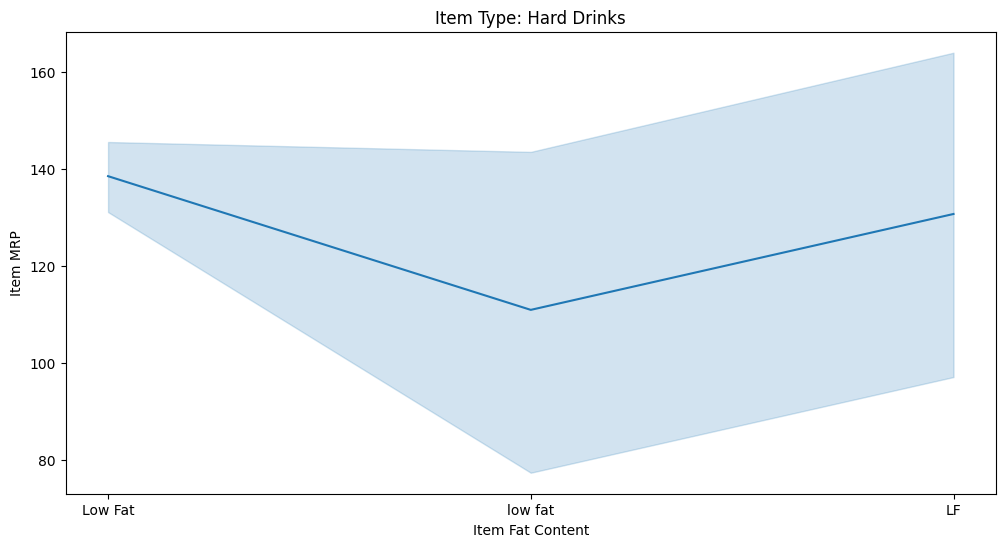

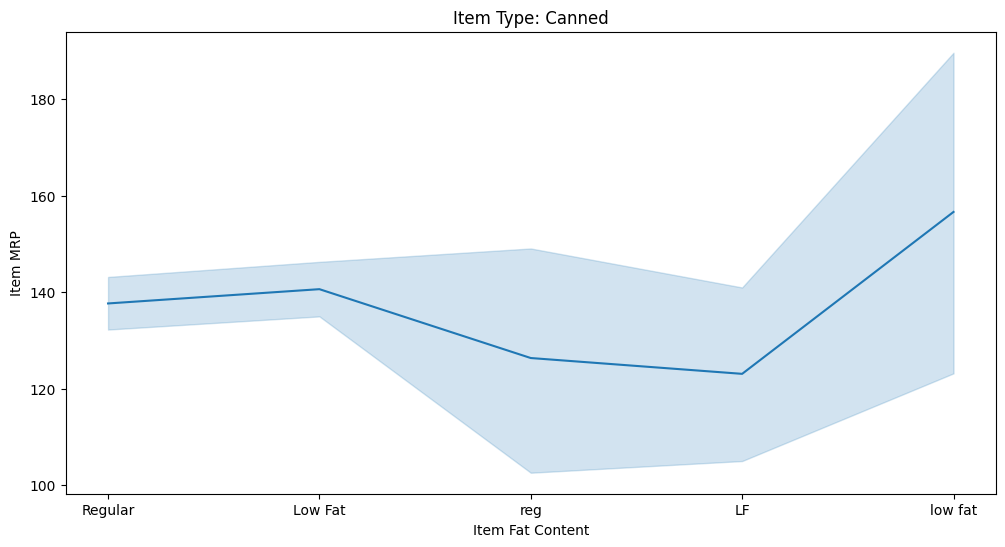

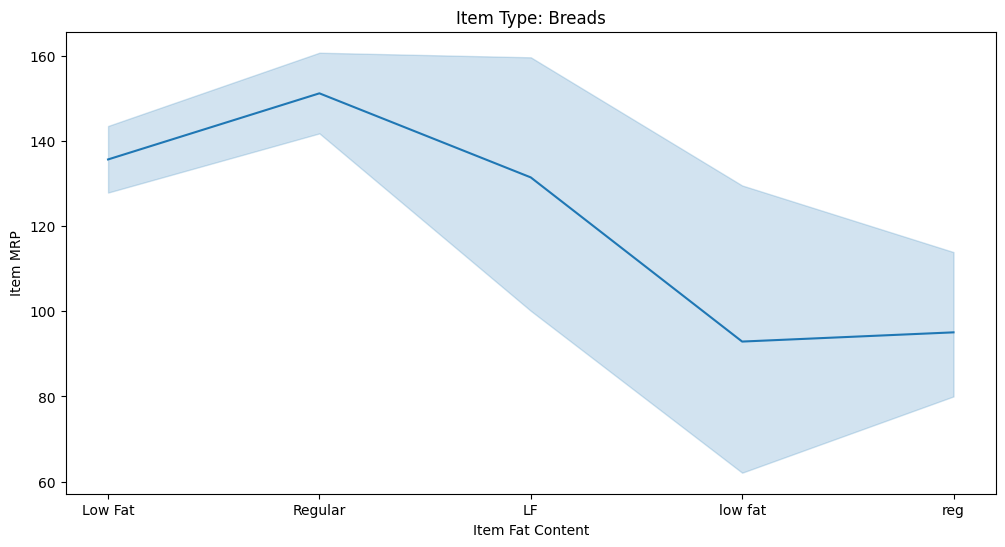

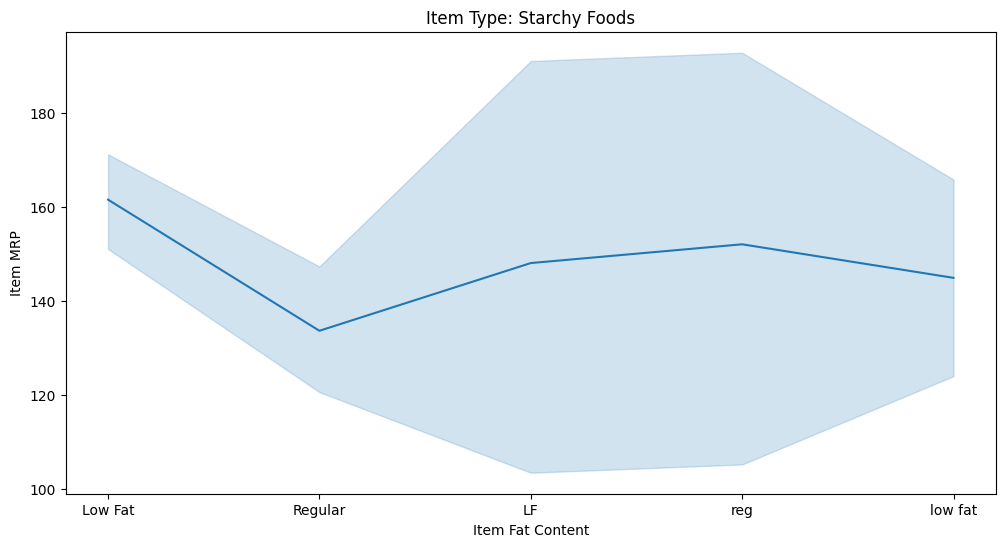

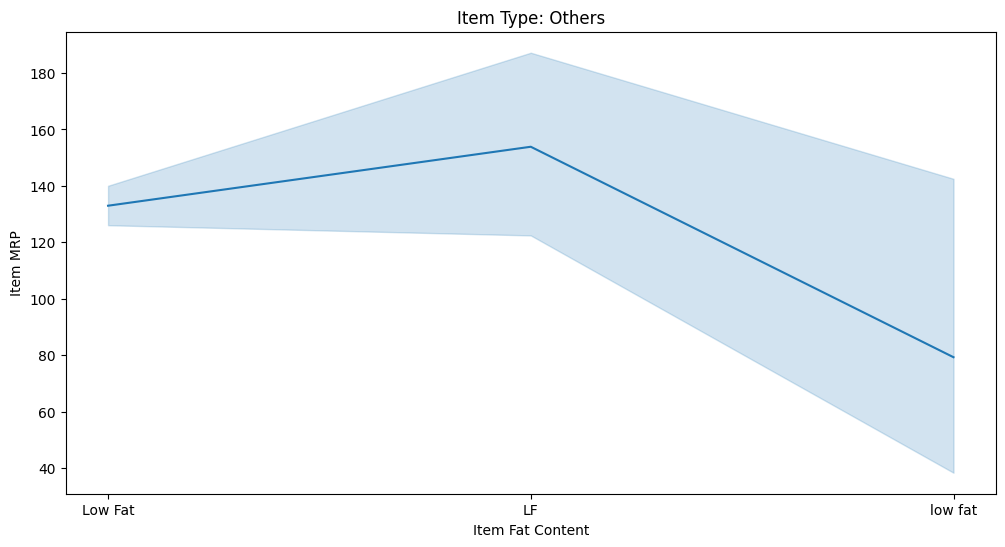

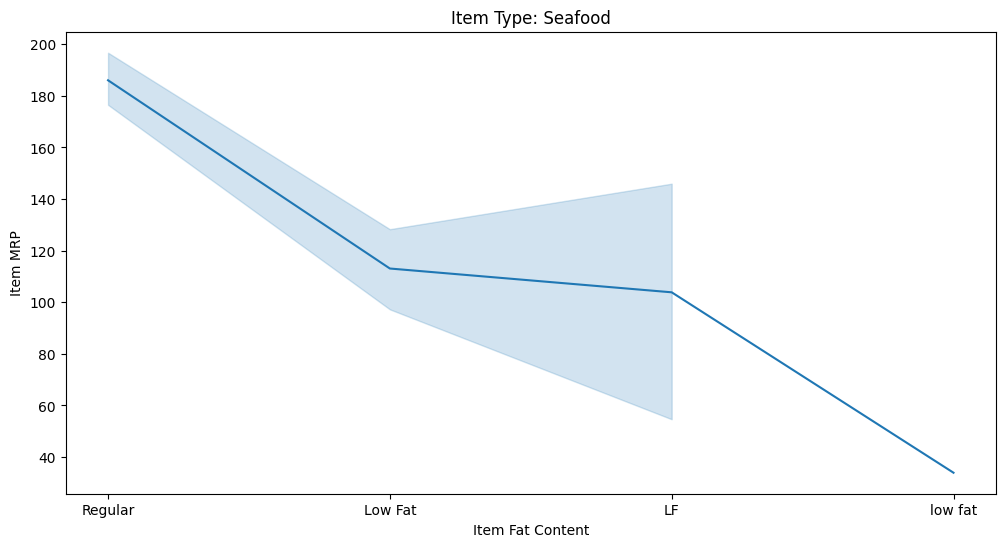

In [234]:
item_types = data["Item_Type"].unique()

for i, item_type in enumerate(item_types):
    plt.figure(figsize=(12, 6))
    sns.lineplot(y="Item_MRP", x="Item_Fat_Content", data=data[data["Item_Type"] == item_type])
    plt.xlabel("Item Fat Content")
    plt.ylabel("Item MRP")
    plt.title(f"Item Type: {item_type}")
    plt.show()

Text(0.5, 1.0, 'Outlet Type Counts')

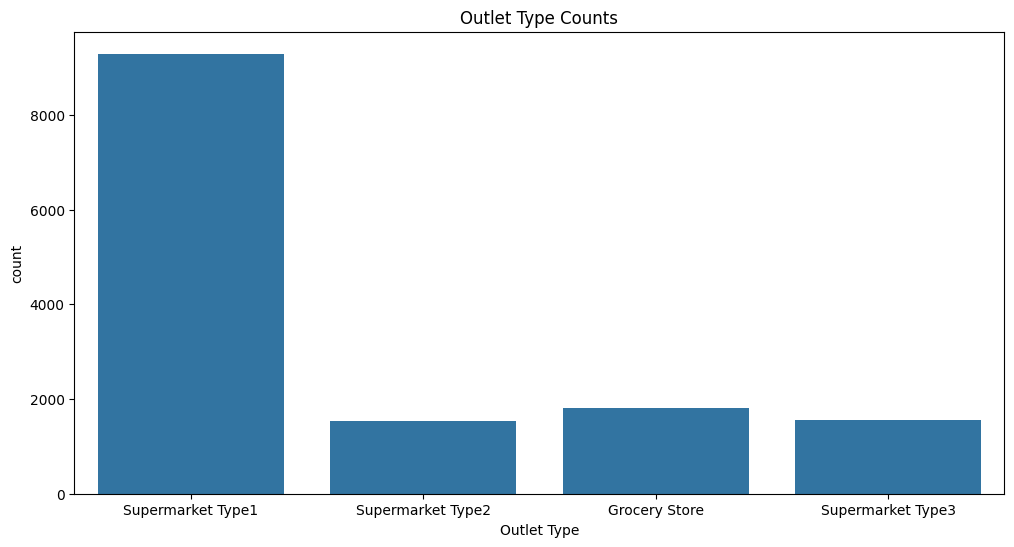

In [235]:
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x="Outlet_Type")
plt.xlabel("Count of Outlet Type")
plt.xlabel("Outlet Type")
plt.title("Outlet Type Counts")

Text(0.5, 1.0, 'Outlet Location Type Count')

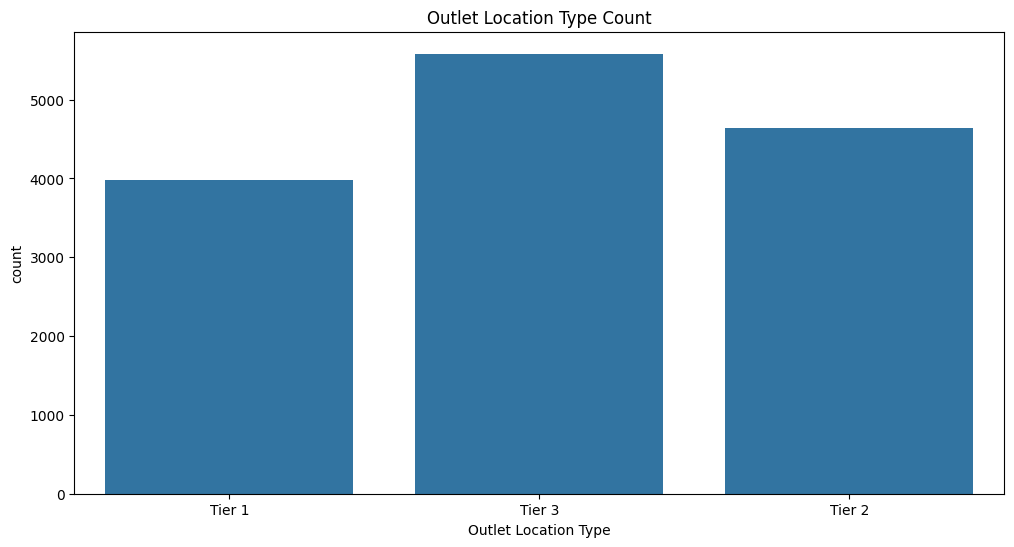

In [236]:
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x="Outlet_Location_Type")
plt.xlabel("Count of Outlet Location Type")
plt.xlabel("Outlet Location Type")
plt.title("Outlet Location Type Count")

Text(0.5, 1.0, 'Outlet Establishment Year VS Outlet Identifiers')

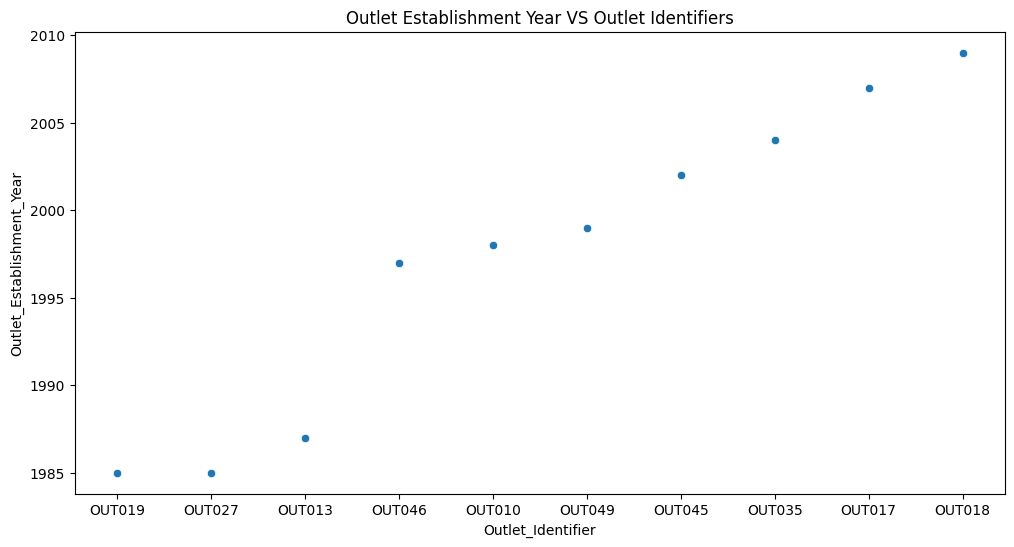

In [237]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=data.groupby(["Outlet_Establishment_Year", "Outlet_Identifier"]).sum(),
    x="Outlet_Identifier",
    y="Outlet_Establishment_Year",
)
plt.title("Outlet Establishment Year VS Outlet Identifiers")

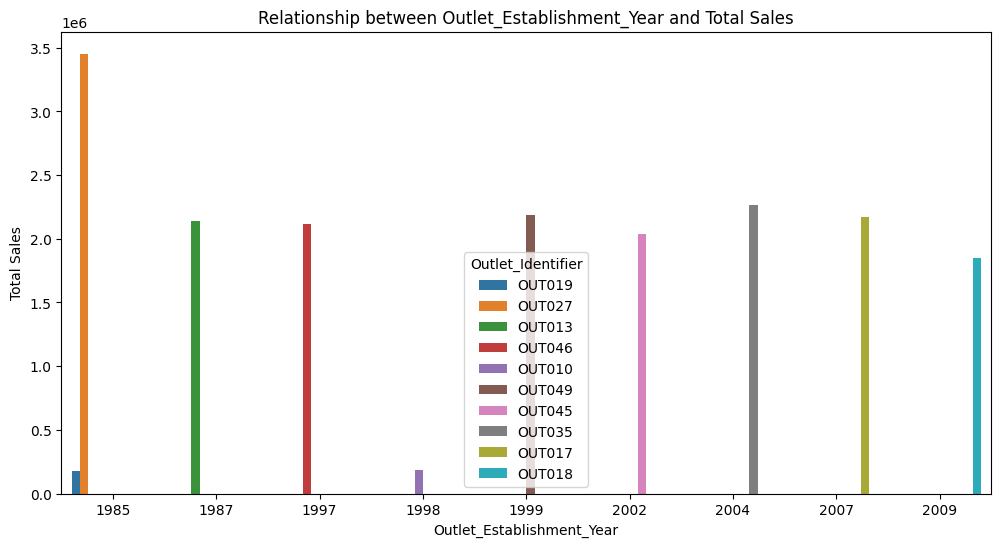

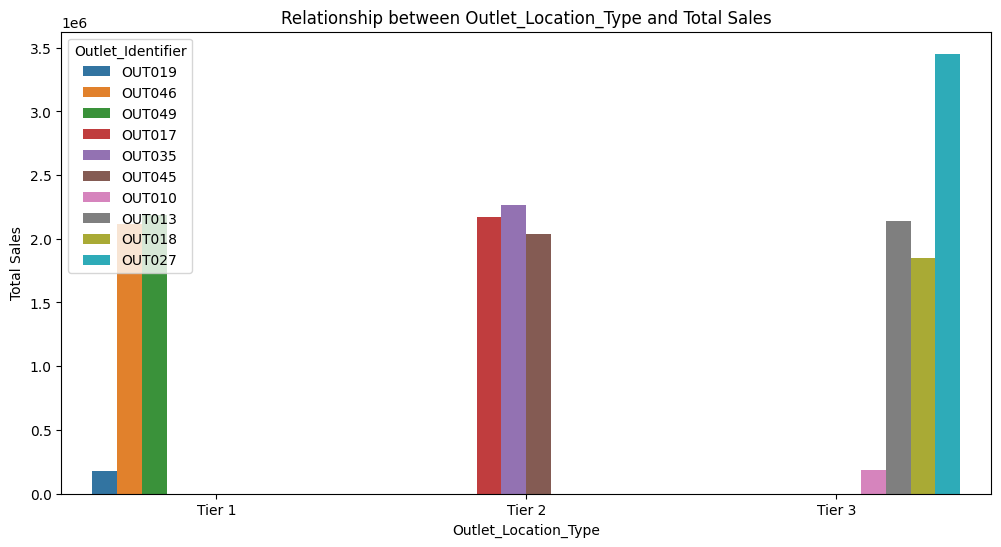

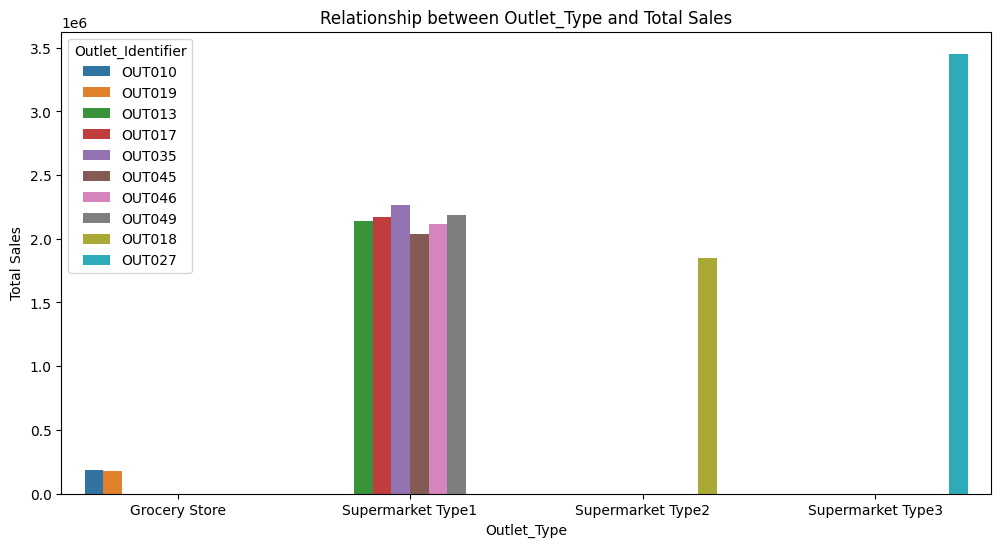

In [238]:
for i in ["Outlet_Establishment_Year", "Outlet_Location_Type", "Outlet_Type"]:
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=data.groupby([i, "Outlet_Identifier"]).sum(),
        hue="Outlet_Identifier",
        x=i,
        y="Item_Outlet_Sales",
    )
    plt.xlabel(i)
    plt.ylabel("Total Sales")
    plt.title(f"Relationship between {i} and Total Sales")
    plt.show()

# Data preprocessing

We will begin with checking the Item_Fat_Content because that seems to be having sound suspicious unique values. There are different spellings to the same thing, which can be corrected to generalise the fat content, for example:-

- lf, low fat , LF can become Low Fat
- reg can become Regular

In [239]:
print(data["Item_Fat_Content"].unique())
data.replace(
    {"Item_Fat_Content": {"low_fat": "Low Fat", "lf": "Low Fat", "LF": "Low Fat"}},
    inplace=True,
)

data.replace({"Item_Fat_Content": {"reg": "Regular"}}, inplace=True)


print(data["Item_Fat_Content"].unique())

['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
['Low Fat' 'Regular' 'low fat']


## Treat Missing Data

### Treat the missing values for Item Weight

Since the item identifiers are duplicated in the dataset, it is possible that the weight has been entered in one observation but missing in another for the same item identifier, therefore, we are first checking what item identifiers have weights in one of the many recorded observations. We are substituting these observations with the present observation.

We also calculate what item identifiers do not have item weight in any of the recorded observations. We fill these item weight gaps using the mean of the weights of their item types. This has been supported by drawing a distribution plot for the weights of the items grouped by item types, to ensure we are not dealing with any outliers or exceptional cases, that may make our assumption erroneous. 

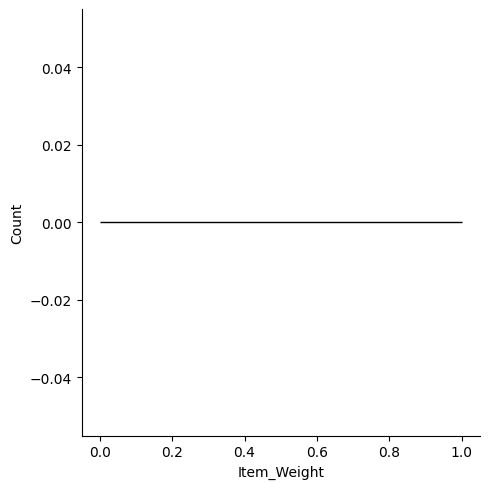

In [240]:
items_without_weight =  set(
    data.loc[data["Item_Weight"].isna()]["Item_Identifier"].unique()
)
items_with_item_weight = set(
    data.loc[-data["Item_Weight"].isna()]["Item_Identifier"].unique()
)
items_with_missing_weight = items_without_weight.intersection(
    items_with_item_weight
)

items_with_absent_weight = items_without_weight.difference(items_with_item_weight)

weight = data[
    (data["Item_Identifier"].isin(items_with_missing_weight))
    & (-data["Item_Weight"].isna())
].iloc[0]["Item_Weight"]

data.loc[
    data["Item_Identifier"].isin(items_with_missing_weight), "Item_Weight"
] = data.loc[
    data["Item_Identifier"].isin(items_with_missing_weight), "Item_Weight"
].fillna(
    weight
)


item_types = set()
item_types.update(
    set(
        data.loc[
            data["Item_Identifier"].isin(items_with_absent_weight),
            "Item_Type",
        ].unique()
    )
)
sns.displot(data=data[data["Item_Type"] == i], x="Item_Weight", kde=True)

average_weights = {}


for i in item_types:
    sns.displot(data=data[data["Item_Type"] == i], x="Item_Weight", kde=True)
    plt.title(f"Item Weight Distribution for Item Type {i}")
    average_weights[i] = data[data["Item_Type"] == i]["Item_Weight"].mean()

for i in items_with_absent_weight:
    data.loc[data["Item_Identifier"] == i, "Item_Weight"] = data.loc[
        data["Item_Identifier"] == i, "Item_Weight"
    ].fillna(
        average_weights.get(data.loc[data["Item_Identifier"] == i, "Item_Type"].iloc[0])
    )

### Treat the missing values for Outlet Size

Number of outlets that have sizes but missing in one of the rows of items: 0
Number of outlets that do not have sizes in any of the rows: 3
Outlets identifiers without any size: {'OUT045', 'OUT017', 'OUT010'}
             Outlet_Type Outlet_Location_Type Outlet_Size
3          Grocery Store               Tier 3         NaN
8      Supermarket Type1               Tier 2         NaN
9      Supermarket Type1               Tier 2         NaN
25     Supermarket Type1               Tier 2         NaN
28         Grocery Store               Tier 3         NaN
...                  ...                  ...         ...
14191      Grocery Store               Tier 3         NaN
14193  Supermarket Type1               Tier 2         NaN
14201  Supermarket Type1               Tier 2         NaN
14202  Supermarket Type1               Tier 2         NaN
14203  Supermarket Type1               Tier 2         NaN

[4016 rows x 3 columns]
['Tier 3' 'Tier 2']
['Grocery Store' 'Supermarket Type1']


Text(0, 0.5, 'Unique Outlet Size Count')

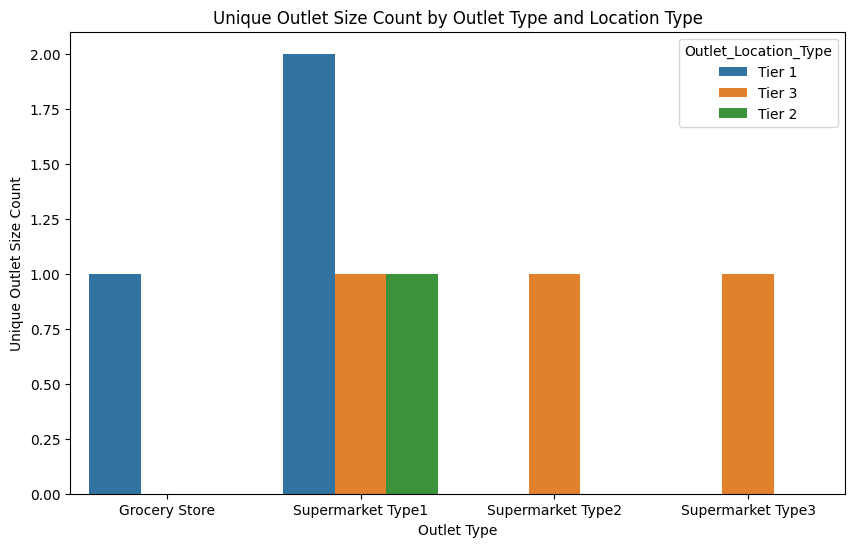

In [241]:
outlets_without_size = set(
    data.loc[data["Outlet_Size"].isna()]["Outlet_Identifier"].unique()
)
outlets_with_size = set(
    data.loc[-data["Outlet_Size"].isna()]["Outlet_Identifier"].unique()
)
outlets_with_missing_size = outlets_without_size.intersection(outlets_with_size)

outlets_with_absent_size = outlets_without_size.difference(outlets_with_size)

print(
    f"Number of outlets that have sizes but missing in one of the rows of items: {len(outlets_with_missing_size)}"
)

print(
    f"Number of outlets that do not have sizes in any of the rows: {len(outlets_with_absent_size)}"
)

print(f"Outlets identifiers without any size: {outlets_with_absent_size}")


print(
    data.loc[
        data["Outlet_Identifier"].isin(outlets_with_absent_size),
        ["Outlet_Type", "Outlet_Location_Type", "Outlet_Size"],
    ]
)

print(
    data.loc[
        data["Outlet_Identifier"].isin(outlets_with_absent_size),
        "Outlet_Location_Type",
    ].unique()
)

print(
    data.loc[
        data["Outlet_Identifier"].isin(outlets_with_absent_size),
        "Outlet_Type",
    ].unique()
)

plt.figure(figsize=(10, 6))
sns.barplot(
    x="Outlet_Type",
    y="Unique_Size_Count",
    hue="Outlet_Location_Type",
    data=data.groupby(["Outlet_Type", "Outlet_Location_Type"])["Outlet_Size"]
    .nunique()
    .reset_index(name="Unique_Size_Count"),
)
plt.title("Unique Outlet Size Count by Outlet Type and Location Type")
plt.xlabel("Outlet Type")
plt.ylabel("Unique Outlet Size Count")


In [242]:
data.loc[
    data["Outlet_Location_Type"].isin(["Tier 3"]),
    ["Outlet_Identifier", "Outlet_Size"],
]["Outlet_Size"].unique()

data.loc[
    data["Outlet_Type"].isin(["Grocery Store"]),
    ["Outlet_Identifier", "Outlet_Size"],
]["Outlet_Size"].unique()

array([nan, 'Small'], dtype=object)

## Feature Engineering

#### Label Encoding Outlet_Location_Type, Label Encoding Outlet_Size

In [243]:
for i in ["Outlet_Location_Type", "Outlet_Size", "Item_Fat_Content"]:
    data[i] = LabelEncoder().fit_transform(data[i].to_numpy())

### One-Hot Encoding Item_Fat_Content, Item_Type, "Outlet_Type"

In [244]:
data = pd.get_dummies(data, columns=["Item_Type", "Outlet_Type"])

#### Min-Max Scaling the Outlet_Establishment_Year

In [245]:
data["Outlet_Establishment_Year"] = MinMaxScaler().fit_transform(
    data["Outlet_Establishment_Year"].values.reshape(-1, 1)
)

In [246]:
data.replace({True: 1, False: 0}, inplace=True)

/var/folders/pc/8h2z2v0d10j98frv7fjdy6nr0000gn/T/ipykernel_84001/202298737.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({True: 1, False: 0}, inplace=True)


### Dropping Unnecessary attributes

We are also removing Item_Visibility because it consists of many outliers

In [247]:
data = data.drop(
    columns=[
        "Item_Identifier",
        "Outlet_Identifier",
        "Item_Type_Others",
        "Item_Visibility",
    ]
)

## Splitting the Data into Train and Test Data

In [248]:
#seperating test data from combined dataset (rows with NaN values in 'Item_Outlet_Sales')
test_df = data[data['Item_Outlet_Sales'].isna()]

#separating training data from combined dataset (without NaN values in 'Item_Outlet_Sales')
train_df = data.dropna(subset=['Item_Outlet_Sales'])

#splitting  training data
X = train_df.drop('Item_Outlet_Sales', axis=1)
y = train_df['Item_Outlet_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Machine Learning

### Plotting Regression Scatter Plot

In [249]:
def plot_regression_scatter(test, results):
    plt.scatter(test, test, color="blue", label="Actual")
    plt.scatter(test, results, color="red", marker="x", label="Predicted")

    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs Predicted Values")
    plt.legend()

    plt.show()

### Plotting the Reqression Residuals

In [250]:
def plot_residuals(test, predictions):
    plt.hist(test - predictions, bins=20)
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    plt.title("Distribution of Residuals")
    plt.show()

### We will using model_data to store the metrics of the models and then visualise them at the end

In [251]:
model_data = []

### Getting model metrics

In [252]:
def get_model_metrics(
    train, val_y, test_prediction_results, train_validation_results, name
):
    mae = mean_absolute_error(val_y, test_prediction_results)
    print(f"Validation Mean Absolute Error: {mae}")

    mse = mean_squared_error(val_y, test_prediction_results)
    print(f"Validation Mean Squared Error {mse}")

    rmse = mean_squared_error(val_y, test_prediction_results, squared=False)
    print(f"Validation Root Mean Squared Error: {rmse}")

    r2 = r2_score(val_y, test_prediction_results)
    print(f"Validation R2 Score for {name}: {r2}")

    train_mae = mean_absolute_error(train, train_validation_results)
    train_mse = mean_squared_error(train, train_validation_results)
    train_rmse = mean_squared_error(train, train_validation_results, squared=False)

    print(f"Training Mean Absolute Error: {train_mae}")
    print(f"Training Mean Squared Error: {train_mse}")
    print(f"Training Root Mean Squared Error: {train_rmse}")

    if train_mae > mae or train_mse > mse or train_rmse > rmse:
        print(f"The model is potentially underfitting.")
    elif train_mae < mae or train_mse < mse or train_rmse < rmse:
        print(f"The model is potentially overfitting.")
    else:
        print(f"The model is well-fit.")

    model_data.append(
        {
            "title": name,
            "r2": r2,
            "mae": mae,
            "mse": mse,
            "rmse": rmse,
            "train_mae": train_mae,
            "train_mse": train_mse,
            "train_rmse": train_rmse,
        }
    )

## Model 1: Random Forest 

### Training a Random Forest Regressor

In [253]:
#creating the ML model (Random Forest Regressor)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

#training the model
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

### Evaluating a Random Forest Regressor

Random Forest Model Evaluation on Training Set:
R-squared (R2 Score): 0.9356489106099739
Mean Squared Log Error: 0.06916810240665115


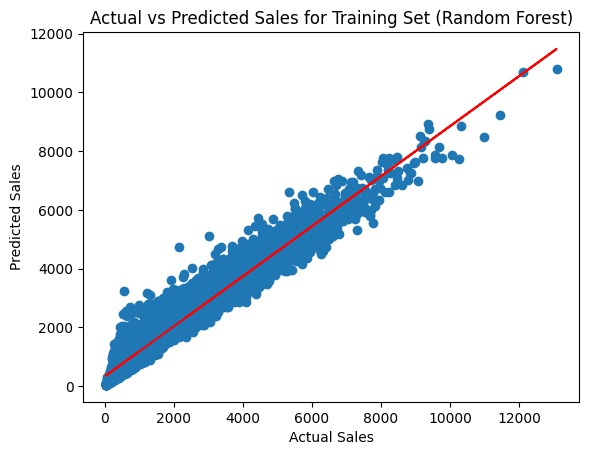

In [254]:
# prediction on training set
y_pred_train_rf = rf_model.predict(X_train)

# model evaluation on training set
r2_train_rf = r2_score(y_train, y_pred_train_rf)
msle_train = mean_squared_log_error(y_train, y_pred_train_rf)

print("Random Forest Model Evaluation on Training Set:")
print("R-squared (R2 Score):", r2_train_rf)
print("Mean Squared Log Error:", msle_train)

# visualizing predicted vs actual values for training set
plt.scatter(y_train, y_pred_train_rf)

# line of best fit
fit = np.polyfit(y_train, y_pred_train_rf, deg=1)
plt.plot(y_train, fit[0] * y_train + fit[1], color="red")

plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales for Training Set (Random Forest)")
plt.show()

### Predicting the test dataset


Random Forest Model Evaluation on Test Set:
R-squared (R2 Score): 0.5399197089504553
Mean Squared Log Error: 0.3130593698063104


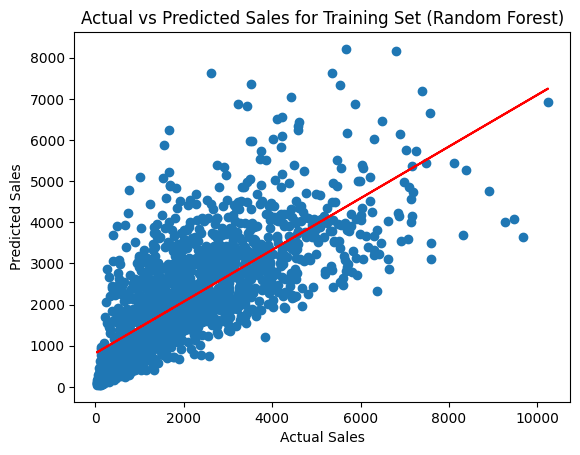

In [255]:
#prediction on test set
y_pred_test_rf = rf_model.predict(X_test)

#model evaluation on test set
r2_test_rf = r2_score(y_test, y_pred_test_rf)
msle_test = mean_squared_log_error(y_test, y_pred_test_rf)

print("\nRandom Forest Model Evaluation on Test Set:")
print("R-squared (R2 Score):", r2_test_rf)
print("Mean Squared Log Error:", msle_test)

#visualizing predicted vs actual values for test set
plt.scatter(y_test, y_pred_test_rf)

#line of best fit
fit = np.polyfit(y_test, y_pred_test_rf, deg=1)
plt.plot(y_test, fit[0] * y_test + fit[1], color='red')

plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales for Training Set (Random Forest)")
plt.show()

model_data.append({"title": "Base Random Forest", "r2": r2_test_rf})


The model's high R2 score (0.937) and low MSLE (0.068) on the training set indicate strong performance, but the lower R2 score (0.555) and higher MSLE (0.306) on the test set suggest overfitting. To address this, a new DataFrame based on feature importance is created to simplify the model and improve generalization.

### Feature importance for the random forest regressor

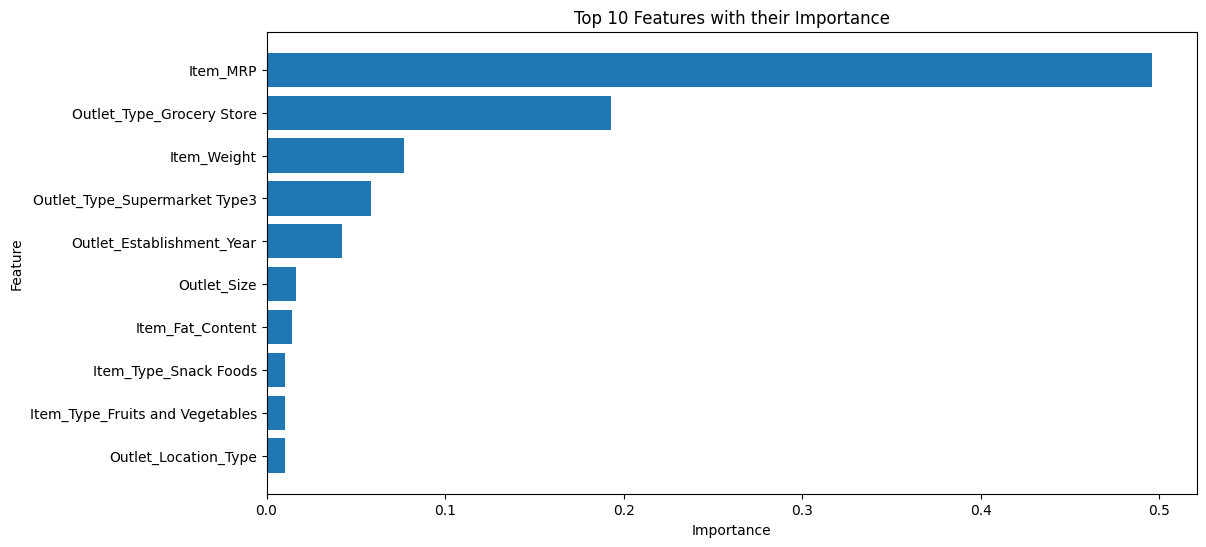

,Feature,Importance
2,Item_MRP,0.495987
21,Outlet_Type_Grocery Store,0.193087
0,Item_Weight,0.077112
24,Outlet_Type_Supermarket Type3,0.058444
3,Outlet_Establishment_Year,0.042094
4,Outlet_Size,0.016315
1,Item_Fat_Content,0.014538
18,Item_Type_Snack Foods,0.010529
12,Item_Type_Fruits and Vegetables,0.010382
5,Outlet_Location_Type,0.010092


In [256]:
#to get feature importances
feature_importances = rf_model.feature_importances_

#creating a df to associate feature names with their importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

#sorting df by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

#plotting the top 10 features
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'][:10][::-1], feature_importance_df['Importance'][:10][::-1])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features with their Importance')
plt.show()

feature_importance_df

### Re-training a new random forest regressor model using the most important features.

In [257]:
#to select features with importance above the threshold (0.02)
selected_features = feature_importance_df.loc[feature_importance_df['Importance'] >= 0.02, 'Feature']

#filtering columns based on selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

#training a new Random Forest model on the selected features
new_rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=5, random_state=42)
new_rf_model.fit(X_train_selected, y_train)

#prediction on the training set
y_pred_train_selected = new_rf_model.predict(X_train_selected)


### Evaluating the newly trained random forest regressor with the most important feature

Random Forest Model Evaluation on Training Set (Selected Features):
R-squared (R2 Score): 0.692364715881617
Mean Squared Log Error: 0.22276395650781902


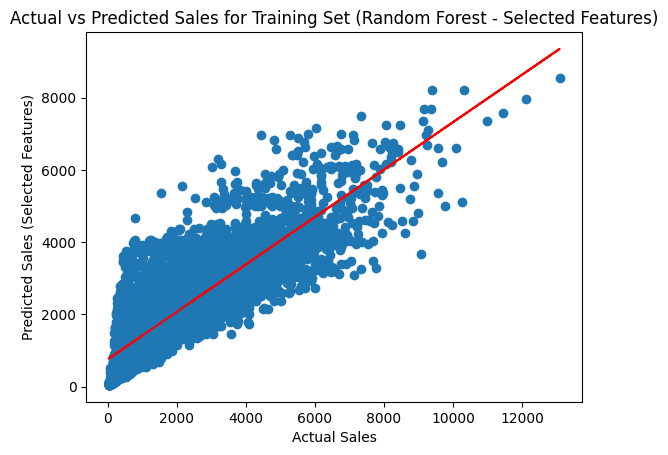

In [258]:
#model evaluation on the training set
r2_train_selected = r2_score(y_train, y_pred_train_selected)
msle_train_sel = mean_squared_log_error(y_train, y_pred_train_selected)

print("Random Forest Model Evaluation on Training Set (Selected Features):")
print("R-squared (R2 Score):", r2_train_selected)
print("Mean Squared Log Error:", msle_train_sel)

#visualizing predicted vs actual values for training set
plt.scatter(y_train, y_pred_train_selected)

#line of best fit
fit = np.polyfit(y_train, y_pred_train_selected, deg=1)
plt.plot(y_train, fit[0] * y_train + fit[1], color='red')

plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales (Selected Features)")
plt.title("Actual vs Predicted Sales for Training Set (Random Forest - Selected Features)")
plt.show()

### Predicting the validation dataset using the newly trained random forest regressor with the most important features


Random Forest Model Evaluation on Test Set (Selected Features):
R-squared (R2 Score): 0.5848392475840254
Mean Squared Log Error: 0.30114554180425834


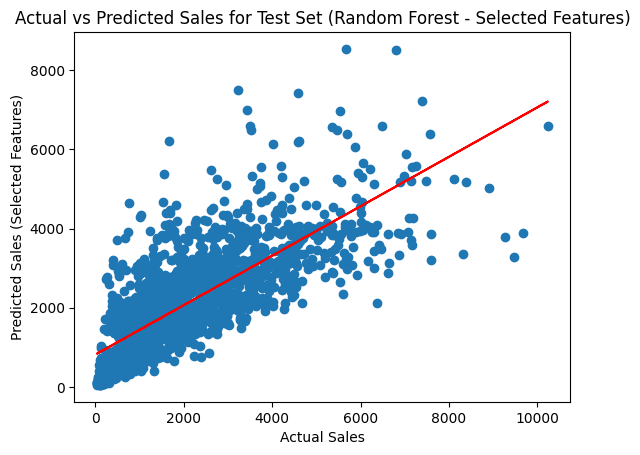

In [259]:
# prediction on test set
y_pred_test_selected = new_rf_model.predict(X_test_selected)

# model evaluation on test set
r2_test_selected = r2_score(y_test, y_pred_test_selected)
msle_test_sel = mean_squared_log_error(y_test, y_pred_test_selected)

print("\nRandom Forest Model Evaluation on Test Set (Selected Features):")
print("R-squared (R2 Score):", r2_test_selected)
print("Mean Squared Log Error:", msle_test_sel)

# visualizing predicted vs actual values for the test set
plt.scatter(y_test, y_pred_test_selected)

# line of best fit
fit = np.polyfit(y_test, y_pred_test_selected, deg=1)
plt.plot(y_test, fit[0] * y_test + fit[1], color="red")

plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales (Selected Features)")
plt.title("Actual vs Predicted Sales for Test Set (Random Forest - Selected Features)")
plt.show()

model_data.append(
    {"title": "Random Forest using important features", "r2": r2_test_selected}
)

**Conclusion**

The updated model shows a slightly lower R2 score (0.706) and higher MSLE (0.217) on the training data compared to the previous one. However, its R2 score (0.599) and MSLE (0.296) on the test data are closer to the training metrics and higher than the previous model's test metrics. 

This indicates improved generalization and better overall performance, highlighting the effectiveness of the adjustment based on feature importance.

## Model 2: XGBoost Regressor


XGBoost Regressor is like a super-smart tool for predicting numbers in things like prices or scores. It's really good at learning from examples and making accurate guesses, making it handy for tasks where you want to predict numerical values. XGBoost Regressor is tree-based because it organizes its predictions into a tree-like structure. This helps it break down complex decision-making processes, making it easier to understand and more powerful for tasks like predicting values based on various factors. XGBoost is one of the ensemble learning methods. XGBoost expects to have the base learners which are uniformly bad at the remainder so that when all the predictions are combined, bad predictions cancels out and better one sums up to form final good predictions.

### Training

In [260]:
def train_xgb(x_train, train_labels, x_test, test_labels):
    dtrain = DMatrix(x_train, label=train_labels)
    dtest = DMatrix(x_test, label=test_labels)

    eval_data = [(dtrain, "train"), (dtest, "eval")]

    params = {"objective": "reg:squarederror", "learning_rate": 0.15}
    xgb_model = train(params, dtrain, num_boost_round=50, evals=eval_data)
    return xgb_model, dtrain, dtest


xgb_model, dtrain, dtest = train_xgb(X_train, y_train, X_test, y_test)

[0]	train-rmse:1568.57062	eval-rmse:1504.41856
[1]	train-rmse:1449.05768	eval-rmse:1388.17768
[2]	train-rmse:1355.50583	eval-rmse:1297.15913
[3]	train-rmse:1283.11684	eval-rmse:1228.09549
[4]	train-rmse:1226.82320	eval-rmse:1174.11756
[5]	train-rmse:1184.68635	eval-rmse:1133.82851
[6]	train-rmse:1152.40163	eval-rmse:1104.44881
[7]	train-rmse:1127.89585	eval-rmse:1084.12876
[8]	train-rmse:1109.07445	eval-rmse:1068.17896
[9]	train-rmse:1094.20991	eval-rmse:1057.49649
[10]	train-rmse:1083.41239	eval-rmse:1050.22408
[11]	train-rmse:1074.67409	eval-rmse:1045.10446
[12]	train-rmse:1068.18799	eval-rmse:1041.24915
[13]	train-rmse:1062.83657	eval-rmse:1039.16591
[14]	train-rmse:1057.89239	eval-rmse:1036.81983
[15]	train-rmse:1053.88267	eval-rmse:1036.83294
[16]	train-rmse:1049.15398	eval-rmse:1036.40584
[17]	train-rmse:1046.10020	eval-rmse:1035.98442
[18]	train-rmse:1042.86424	eval-rmse:1036.13649
[19]	train-rmse:1039.66152	eval-rmse:1036.92465
[20]	train-rmse:1034.88984	eval-rmse:1036.58989
[2

### Prediction & Evaluation

Validation Mean Absolute Error: 730.2391913166786
Validation Mean Squared Error 1112401.0072610776
Validation Root Mean Squared Error: 1054.7042273837142
Validation R2 Score for Base XGBoost: 0.5907235988637014
Training Mean Absolute Error: 676.2891845703125
Training Mean Squared Error: 912024.75
Training Root Mean Squared Error: 954.9998779296875
The model is potentially overfitting.


/Users/bhavyababuta/.local/share/virtualenvs/big-mart-sales-prediction-PPpMiLjs/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/bhavyababuta/.local/share/virtualenvs/big-mart-sales-prediction-PPpMiLjs/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


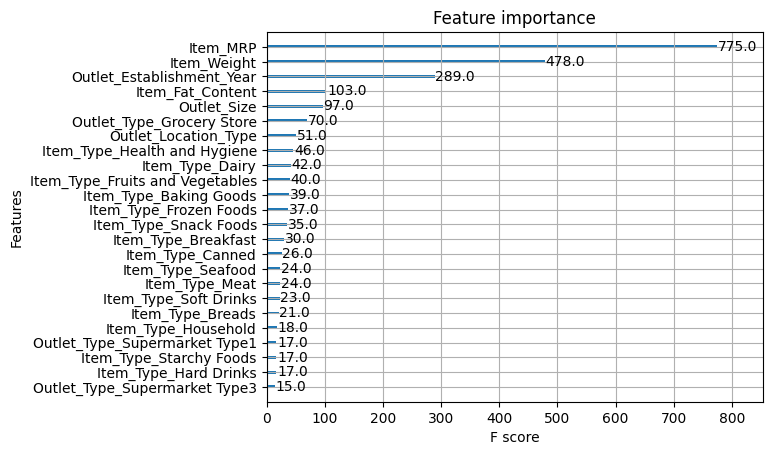

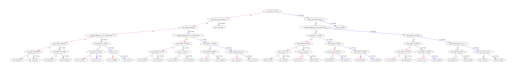

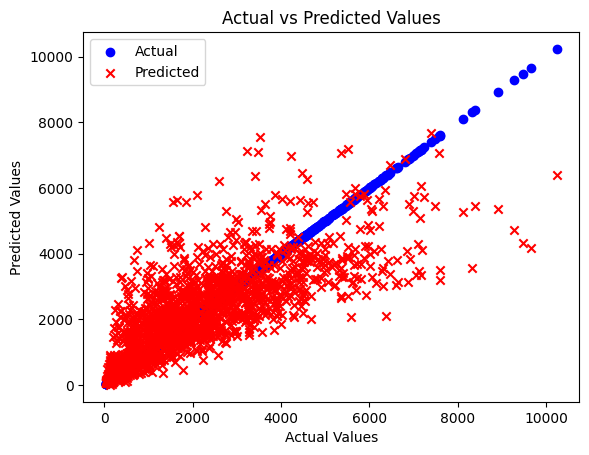

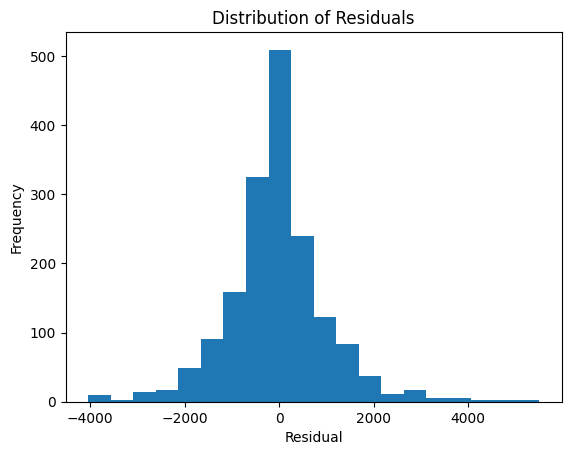

In [261]:
def evaluate_xgboost(model, train, x_val, y_val, name):
    pred = model.predict(train)
    preds2 = model.predict(x_val)

    get_model_metrics(train.get_label(), y_val, preds2, pred, name)

    plot_importance(model)
    plt.show()

    plot_tree(model)
    plt.show()

    plot_regression_scatter(y_val, preds2)

    plot_residuals(y_val, preds2)


evaluate_xgboost(
    xgb_model,
    dtrain,
    dtest,
    y_test,
    "Base XGBoost",
)

### Re-training and evaluating a new XGBoostRegressor using the most important features.

This code segment focuses on feature selection and evaluation of an XGBoost model. Firstly, the importance scores for each feature are obtained using the get_fscore() function, resulting in a dictionary named feature_importance. Subsequently, features with importance scores exceeding a specified threshold (200 in this case) are selected and stored in the top_features list. A new XGBoost model (xgb_model_selected) is then trained using the training data (X_train[top_features] and y_train), and predictions are generated for the test set (X_test[top_features]). Finally, the model's performance is evaluated using the evaluate_xgboost function, which compares the predictions (test_predictions_selected) with the actual labels (y_test). This process allows for feature prioritization and model assessment, enabling more streamlined and efficient model training based on the most relevant features.

[0]	train-rmse:1612.05836	eval-rmse:1552.19862
[1]	train-rmse:1529.90422	eval-rmse:1477.24178
[2]	train-rmse:1466.02199	eval-rmse:1419.03504
[3]	train-rmse:1417.43187	eval-rmse:1377.43276
[4]	train-rmse:1379.59915	eval-rmse:1346.50409
[5]	train-rmse:1350.78913	eval-rmse:1324.41757
[6]	train-rmse:1328.42678	eval-rmse:1308.38379
[7]	train-rmse:1312.06601	eval-rmse:1295.56877
[8]	train-rmse:1300.61206	eval-rmse:1288.30461
[9]	train-rmse:1290.26584	eval-rmse:1281.73387
[10]	train-rmse:1283.09762	eval-rmse:1277.15681
[11]	train-rmse:1277.46092	eval-rmse:1275.68512
[12]	train-rmse:1271.12305	eval-rmse:1272.65267
[13]	train-rmse:1266.30110	eval-rmse:1272.60903
[14]	train-rmse:1261.47235	eval-rmse:1272.61739
[15]	train-rmse:1257.21288	eval-rmse:1272.13958
[16]	train-rmse:1254.41455	eval-rmse:1271.61863
[17]	train-rmse:1250.40331	eval-rmse:1273.92964
[18]	train-rmse:1247.20167	eval-rmse:1277.22471
[19]	train-rmse:1244.67842	eval-rmse:1277.63159
[20]	train-rmse:1241.40735	eval-rmse:1276.38763
[2

/Users/bhavyababuta/.local/share/virtualenvs/big-mart-sales-prediction-PPpMiLjs/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/bhavyababuta/.local/share/virtualenvs/big-mart-sales-prediction-PPpMiLjs/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


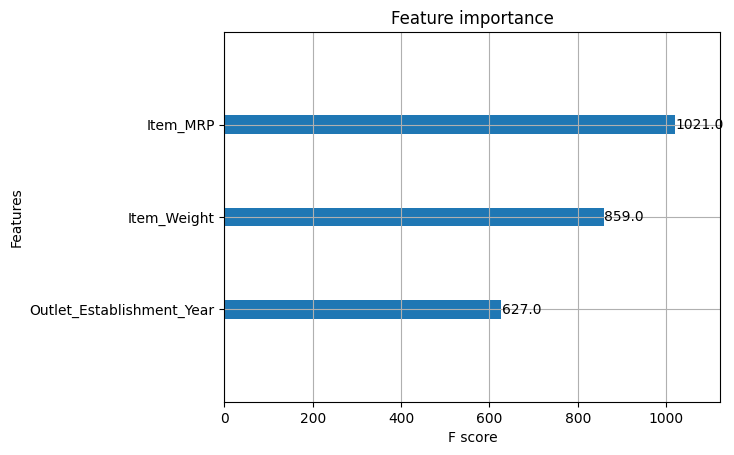

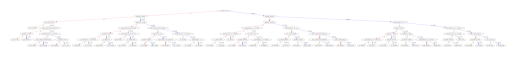

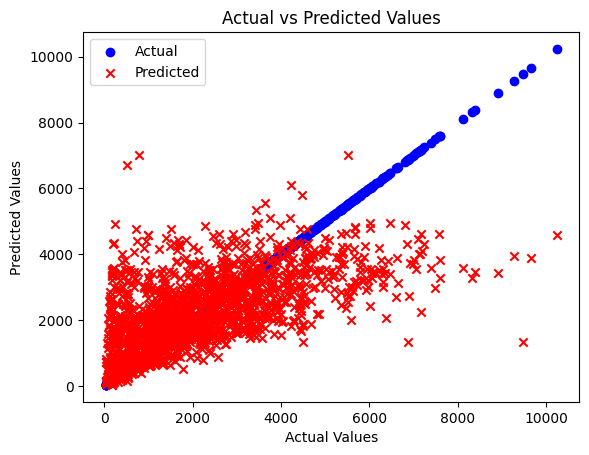

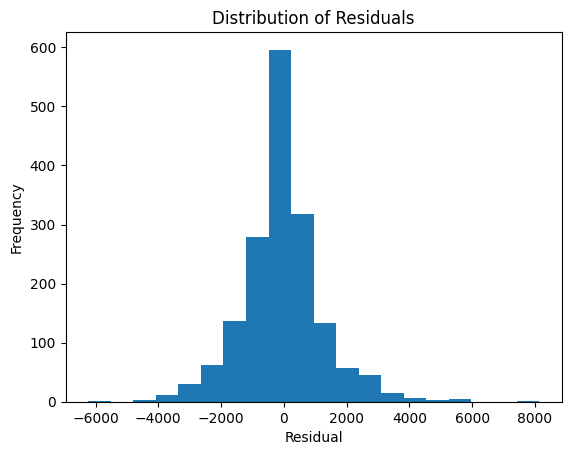

In [262]:
feature_importance = xgb_model.get_fscore()

top_features = [feature for feature, score in feature_importance.items() if score > 200]

xgb_model_imp, dtrain_imp, dtest_imp = train_xgb(
    X_train[top_features], y_train, X_test[top_features], y_test
)

evaluate_xgboost(
    xgb_model_imp, dtrain_imp, dtest_imp, y_test, "XGBoost using important features"
)

### Conclusion

A good model would have residuals that are normally distributed around 0. However, the XGBoost is performing even worse than Random Forest Regressor

## Model 3. Ridge Regression

In [263]:
def train_ridge(train, train_labels):
    return Ridge().fit(train, train_labels)

In [276]:
def evaluate_ridge(train, val, y_val, model):
    pred = model.predict(train)
    pred2 = model.predict(val)

    plot_regression_scatter(y_val, pred2)
    # get_model_metrics(train, y_val, pred2, pred, "Ridge Regression")

    coeff = pd.DataFrame(train.columns)
    coeff["Coefficient Estimate"] = pd.Series(model.coef_)
    print(coeff.sort_values(by="Coefficient Estimate", ascending=False))

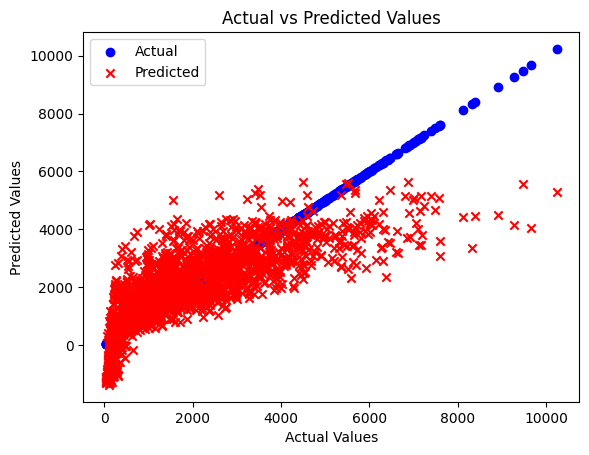

                                  0  Coefficient Estimate
24    Outlet_Type_Supermarket Type3           1707.332449
3         Outlet_Establishment_Year            327.640628
17                Item_Type_Seafood            256.328776
22    Outlet_Type_Supermarket Type1            216.499387
8               Item_Type_Breakfast            101.778334
12  Item_Type_Fruits and Vegetables             80.582748
9                  Item_Type_Canned             62.737491
20          Item_Type_Starchy Foods             57.420624
14     Item_Type_Health and Hygiene             53.701288
1                  Item_Fat_Content             41.838182
16                   Item_Type_Meat             40.105407
6            Item_Type_Baking Goods             36.229615
13            Item_Type_Hard Drinks             35.797034
18            Item_Type_Snack Foods             29.124275
11           Item_Type_Frozen Foods             26.823850
15              Item_Type_Household             22.344953
2             

In [277]:
ridge = train_ridge(X_train, y_train)

evaluate_ridge(X_train, X_test, y_test, ridge)